In [1]:
import numpy as np
from itertools import combinations, product, permutations
import warnings
import time
from idQ import is_parallel, is_strictly_less_than, is_less_equal_than, generate_binary_vectors, generate_permutations,preserve_partial_order
from idQ import contains_identity_submatrix, identifiability
from idQ import representative_node_set, item_node_set, Phi_mat, T_mat
from idQ import check_three_column_submatrices
import random
from expr_function import random_generate_Q, generate_canonical_matrices, binary_matrix_to_string, sort_lexicographically, random_generate_Q, prop_check, sort_binary_matrix
import sys

import itertools
import cProfile
import random
from idQ import T_mat
import networkx as nx
import matplotlib.pyplot as plt

from draw_G import draw_G_K4, draw_G_K5

In [2]:
from functools import lru_cache

In [ ]:
from pysat.card import CardEnc, EncType
from pysat.formula import CNF
from pysat.card import CardEnc

## Optional, idQ functions

In [102]:
from pysat.formula import CNF, IDPool
from pysat.solvers import Solver                    # CaDiCaL via 'cadical'


def equality_chain_leq(cnf, A, B, pool):
    """
    Add clauses for A <=_lex B.
    Returns the literal id of e_last  (==1 iff A==B).
    """
    n = len(A)
    e  = [pool.id(('e', i)) for i in range(n)]

    cnf.append([e[0]])                       # e[-1] := True

    for i in range(n):
        ei   = e[i]
        eim1 = e[i-1] if i > 0 else e[0]
        a, b = A[i], B[i]

        cnf.extend([
            [-ei,  eim1],                    # ei -> e_{i-1}
            [-ei, -a,  b],                   # ei -> (¬a ∨  b)
            [-ei,  a, -b],                   # ei -> ( a ∨ ¬b)
            [-eim1,  a,  b,  ei],            # e_{i-1}&a=b -> ei
            [-eim1, -a, -b, ei],
            [-eim1, -a, b]                   # lex condition
        ])
    return e[-1]                             # e_last


def add_lex_lt(cnf, A, B, pool):
    """Encode A <_lex B."""
    e_last = equality_chain_leq(cnf, A, B, pool)
    cnf.append([-e_last])                    # forbid equality


def add_lex_gt(cnf, A, B, pool):
    """Encode A >_lex B  (just swap)."""
    add_lex_lt(cnf, B, A, pool)


In [27]:
def lex_lt(cnf, A, B, pool):
    """
    Add A <_lex B  (strict) with a clean equality chain.
    size: 6n + 1 clauses, n aux vars.
    """
    n = len(A)
    e = [pool.id(('e', i, id(A))) for i in range(n)]   # unique per call

    T = pool.id(('T', id(A)))   # a fresh literal that we set to True
    cnf.append([T])             # unit clause  (T = True)

    prev = T                    # e_{-1}

    for i in range(n):
        ai, bi = A[i], B[i]

        # ei <-> (prev & (ai == bi))
        cnf.append([-e[i],  prev])          # ei -> prev
        cnf.append([-e[i], -ai,  bi])       # ei -> (ai → bi)
        cnf.append([-e[i],  ai, -bi])       # ei -> (bi → ai)
        cnf.append([-prev,  ai,  bi,  e[i]])
        cnf.append([-prev, -ai, -bi, e[i]])

        # lex condition for this position:  prev -> (¬ai ∨ bi)
        cnf.append([-prev, -ai, bi])

        prev = e[i]

    # strict:  forbid full equality
    cnf.append([-prev])
def lex_gt(cnf, A, B, pool):
    lex_lt(cnf, B, A, pool)


In [55]:
def add_lex_gt(cnf, A, B, pool):
    """
    Enforce A >_lex B (strict) in the CNF `cnf`.
    A, B: lists of literal IDs (MSB first).
    `pool` is a pysat IDPool to create fresh vars.
    """
    if len(A) != len(B):
        raise ValueError("A and B must have the same length")
    n = len(A)
    # 1) sentinel T = true
    T = pool.id(('T', id(A), id(B)))
    cnf.append([T])

    prev = T
    d_vars = []
    for i in range(n):
        ai, bi = A[i], B[i]

        # 2) eq_i ↔ (prev ∧ (ai ↔ bi))
        eq = pool.id(('e', i, id(A), id(B)))
        # eq -> prev
        cnf.append([-eq, prev])
        # eq -> (ai -> bi)  and  eq -> (bi -> ai)
        cnf.append([-eq, -ai, bi])
        cnf.append([-eq,  ai, -bi])
        # (prev ∧ ai ∧ bi) -> eq
        cnf.append([-prev, -ai, -bi, eq])
        # (prev ∧ ¬ai ∧ ¬bi) -> eq
        cnf.append([-prev,  ai,  bi, eq])

        # 3) d_i ↔ (prev ∧ ai ∧ ¬bi)
        d = pool.id(('d', i, id(A), id(B)))
        # d -> prev, d -> ai, d -> ¬bi
        cnf.append([-d, prev])
        cnf.append([-d, ai])
        cnf.append([-d, -bi])
        # (prev ∧ ai ∧ ¬bi) -> d
        cnf.append([-prev, -ai, bi, d])

        d_vars.append(d)
        prev = eq

    # 4) at least one d_i must be true
    cnf.append(d_vars)


In [4]:
from idQ import get_basis, generate_unique_Q_bars, check_two_column_submatrices
from idQ import check_three_column_submatrices, get_Q_from_Qbasis, direct_check_id, unique_response_columns

In [5]:
import numpy as np
import itertools
import gurobipy as gp
from gurobipy import GRB
from solve_Q_identifiability import classify_row_pairs
from solve_Q_identifiability import row_masks, distances
from idQ import lex_sort_columns

In [6]:
def unique_pattern_supports(Q):
    """
    Returns all nontrivial supports S = {j | \aaa ⪰ q_j}, for each representative \aaa.
    *excluding* the empty set and the full set {0,…,J-1}.
    """
    J, K = Q.shape
    R = {tuple([0]*K)}
    for j in range(J):
        row = Q[j]
        new = []
        for aaa in R:
            merged = tuple(aaa[k] | row[k] for k in range(K))
            if merged not in R:
                new.append(merged)
        R.update(new)
    # Build and filter supports
    full = frozenset(range(J))
    supports = []
    for aaa in R:
        S = frozenset(j for j in range(J) if all(aaa[k] >= Q[j][k] for k in range(K)))
        if S and S is not full:
            supports.append(set(S))
    return supports

In [44]:
import numpy as np
from pysat.formula import CNF, IDPool
from pysat.card    import CardEnc
from pysat.solvers import Solver


# ----------------------------------------------------------------------
#  helper 1 :  strictly lexicographically decreasing columns
# ----------------------------------------------------------------------
def add_lex_decreasing(cnf, pool, x_var, J, K):
    """column k >_lex column k+1  for all k"""
    for k in range(K-1):
        diff_lits = []
        for i in range(J):
            v = pool.id(('v', k, i))          # witness "first difference at row i"
            diff_lits.append(v)
            # v -> x[i,k]=1  and  x[i,k+1]=0
            cnf.append([-v,  x_var[i][k]])
            cnf.append([-v, -x_var[i][k+1]])
            # v -> rows r<i equal
            for r in range(i):
                cnf.append([-v, -x_var[r][k],   x_var[r][k+1]])
                cnf.append([-v,  x_var[r][k],  -x_var[r][k+1]])
        # need some first difference
        cnf.append(diff_lits)


# ----------------------------------------------------------------------
#  helper 2 :  X != Q
# ----------------------------------------------------------------------
def add_neq_Q(cnf, x_var, Q):
    diff_clause = []
    for j, row in enumerate(Q):
        for k, qjk in enumerate(row):
            diff_clause.append(-x_var[j][k] if qjk else x_var[j][k])
    cnf.append(diff_clause)


# ----------------------------------------------------------------------
#  helper 3 :  1 <= row-sum <= Cardbound[j]
# ----------------------------------------------------------------------
def add_row_cardinality(cnf, pool, x_var, Cardbound):
    J, K = len(x_var), len(x_var[0])
    for j in range(J):
        row_lits = x_var[j]
        # at least one 1
        cnf.append(row_lits)
        # at most Cardbound[j] ones
        b = Cardbound[j]
        if b < 1:
            raise ValueError("Cardbound must be >=1 to coexist with 'at least one'")
        if b < K:        # if b==K the constraint is vacuous
            enc = CardEnc.atmost(lits=row_lits, bound=b, vpool=pool)
            cnf.extend(enc.clauses)


# ----------------------------------------------------------------------
#  helper 4 :  exact U-constraint
# ----------------------------------------------------------------------
def add_U_constraint(cnf, pool, x_var, U):
    """
    U : list of lists (each list is a subset of row indices)
    """
    J, K = len(x_var), len(x_var[0])
    for S_idx, S in enumerate(U):
        S = set(S)
        for jp in range(J):
            if jp in S:
                continue
            witness = []
            for k in range(K):
                c = pool.id(('c', S_idx, jp, k))
                witness.append(c)
                # forward  c -> x[jp,k]=1   and  forall j in S: x[j,k]=0
                cnf.append([-c, x_var[jp][k]])
                for j in S:
                    cnf.append([-c, -x_var[j][k]])
                # backward (x[jp,k] & big_and_{j in S} ¬x[j,k]) -> c
                clause = [-x_var[jp][k]] + [x_var[j][k] for j in S] + [c]
                cnf.append(clause)
            # need at least one witnessing column
            cnf.append(witness)

# ----------------------------------------------------------------------
#  main driver
# ----------------------------------------------------------------------
def solve_identifiability_SAT(Q, solver_name='cadical195'):
    """
    Parameters
    ----------
    Q : np.ndarray (J x K) with 0/1
    Cardbound : list length J, each >=1
    U : list of lists, each list is a subset of {0,...,J-1}
    Returns
    -------
    True  if SAT (some X exists)
    False if UNSAT
    """
    J, K = Q.shape
    Cardbound = K - distances(Q)
    U = unique_pattern_supports(Q)
    pool = IDPool()
    x_var = [[pool.id(('x', j, k)) for k in range(K)] for j in range(J)]
    cnf = CNF()

    add_lex_decreasing(cnf, pool, x_var, J, K)
    add_neq_Q(cnf, x_var, Q)
    add_row_cardinality(cnf, pool, x_var, Cardbound)
    add_U_constraint(cnf, pool, x_var, U)

    with Solver(name=solver_name, bootstrap_with=cnf.clauses) as s:
        found = s.solve()
        if not found:
            return None
        model = set(s.get_model())
        X_mat = np.zeros_like(Q)
        for j in range(J):
            for k in range(K):
                if x_var[j][k] in model:
                    X_mat[j, k] = 1
        return X_mat

In [41]:
bugQ

array([[0, 0, 1, 1],
       [0, 1, 0, 1],
       [1, 0, 1, 1],
       [1, 1, 0, 0],
       [1, 1, 1, 0]])

In [42]:
bugQbar

array([[0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 1],
       [1, 0, 0, 0],
       [1, 1, 0, 0]])

In [43]:
distances(bugQ)

array([2, 2, 1, 2, 1])

In [151]:
solve_identifiability_SAT(Q_sorted)

In [137]:
import numpy as np

Q = np.array([
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0],
    [1,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [1,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,1,0,0,0,0,1,0,0,0],
    [0,0,0,0,1,0,0,1,0,1],
    [0,0,1,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,1],
    [0,0,0,0,1,1,0,0,0,1],
    [1,0,1,0,0,0,0,0,1,1],
    [0,1,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,1,0,0,0,1],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,1],
    [0,1,0,1,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,0],
    [1,1,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,1],
    [0,0,1,0,1,0,1,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [1,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,1,1,0,1,0,0],
    [0,0,1,1,0,0,1,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [1,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,1,1,0,1,0],
], dtype=int)

print("Q.shape =", Q.shape)  # should output (50, 10)


Q.shape = (50, 10)


In [143]:
(Q_basis, basis_to_original, orig_indices_for_basis,
     Q_unique, unique_to_original, basis_to_unique) = get_basis(Q)
Q_sorted, sorted_to_original = lex_sort_columns(Q_basis)

In [ ]:
from ortools.sat.python import cp_model
from itertools import product

def solve_identifiability_Q_cpsat(Q, Xcand = None):
    """
    CP-SAT feasibility check for Q-matrix identifiability.

    Arguments:
      Q:        A J×K binary matrix (list of lists or numpy array).
      time_limit: maximum solve time in seconds (default 30).

    Returns:
      (identifiable, Qbar_candidate)
      - identifiable = True  if no alternate Qbar exists (so Q IS identifiable),
                       False if we find a Qbar ≉ Q that explains all patterns.
      - Qbar_candidate = the found J×K matrix (list of lists) when identifiable=False,
                         otherwise None.
    """
    J, K = Q.shape

    # 1) Compute unique response patterns Phi
    supports = unique_pattern_supports(Q)
    A = len(supports)

    model = cp_model.CpModel()

    # 2) Decision variables
    x = [[model.NewBoolVar(f"x_{j}_{k}") for k in range(K)] for j in range(J)]
    h = [[model.NewBoolVar(f"h_{a}_{k}") for k in range(K)] for a in range(A)]
    # if Xcand is not None:
    #     # Xcand is a J×K list (or array) with 0/1 entries
    #     for j in range(J):
    #         for k in range(K):
    #             model.Add(x[j][k] == Xcand[j][k])


    
    # --- norm constraints ------------------------------
    # compute dist[j] = d(q_j) from your existing distances(Q) function
    dist = distances(Q)  # array of length J

    for j in range(J):
        # at least one skill per item
        model.Add( sum(x[j][k] for k in range(K)) >= 1 )
        # at most K - dist[j] skills per item
        model.Add( sum(x[j][k] for k in range(K)) <= K - dist[j] )

    
    # 3) OR-constraint: for each pattern a and each skill k,
    #    h[a][k] == OR_{j in S_a} x[j][k],  where S_a = { j | Phi[a][j] == 1 }
    for a, S_a in enumerate(supports):
        for k in range(K):
            if S_a:
                # If any x[j,k] is 1 for j∈S, then h[a][k] must be 1:
                for j in S_a:
                    model.AddImplication(x[j][k], h[a][k])
                # If all x[j,k]==0 for j∈S, then h[a][k] must be 0:
                #   (¬x[j1,k] ∧ ¬x[j2,k] ∧ …) ⇒ ¬h[a][k]
                clause = [x[j][k].Not() for j in S_a] + [h[a][k].Not()]
                model.AddBoolOr(clause)
            else:
                # If pattern a has no correct items at all, it can never have any skill:
                model.Add(h[a][k] == 0)

    # 4) Non-covering constraint: for each pattern a and each item j NOT in S_a,
    #    ∃k s.t. x[j][k]==1 ∧ h[a][k]==0
    for a, S_a in enumerate(supports):
        for j in range(J):
            if j not in S_a:
                # Build a small auxiliary b_{a,j,k} for each k:
                b_vars = []
                for k in range(K):
                    b = model.NewBoolVar(f"b_{a}_{j}_{k}")
                    b_vars.append(b)
                    # b=1 ⇒ x[j,k]=1
                    model.AddImplication(b, x[j][k])
                    # b=1 ⇒ h[a,k]=0
                    model.AddImplication(b, h[a][k].Not())
                # Now require at least one b[a,j,k] = 1
                model.AddBoolOr(b_vars)

    # 5) Forbid the trivial solution x==Q: enforce at least one entry differs
    diff_clause = []
    for j in range(J):
        for k in range(K):
            if Q[j][k] == 1:
                diff_clause.append(x[j][k].Not())
            else:
                diff_clause.append(x[j][k])
    if clause:          
        model.AddBoolOr(diff_clause)
    # 6) Lexicographic non-increasing ordering on columns of x:
    #    For each adjacent pair k, k+1, introduce diff[k][i] for i=0..J
    #    i in [0..J-1] means first difference at row i; i=J means no difference.
    # for k in range(K-1):
    #     diff = [model.NewBoolVar(f"diff_{k}_{i}") for i in range(J+1)]
    #     # exactly one position
    #     model.Add(sum(diff) == 1)
    #     # if first diff at row i < J:
    #     for i in range(J):
    #         # equality above i
    #         for t in range(i):
    #             model.Add(x[t][k] == x[t][k+1]).OnlyEnforceIf(diff[i])
    #         # at i: x[i,k]=1, x[i,k+1]=0
    #         model.Add(x[i][k] == 1).OnlyEnforceIf(diff[i])
    #         model.Add(x[i][k+1] == 0).OnlyEnforceIf(diff[i])
    #     # if no difference at all (diff[J]):
    #     for t in range(J):
    #         model.Add(x[t][k] == x[t][k+1]).OnlyEnforceIf(diff[J])
    
    # 6) Lexicographic ordering via weight encoding
    #    Assign descending powers of two (MSB at row 0).
    weights = [2**(J - 1 - j) for j in range(J)]

    for k in range(K-1):
        # build the two IntExpr’s for column k and k+1
        col_k   = sum(weights[j] * x[j][k]   for j in range(J))
        col_k1  = sum(weights[j] * x[j][k+1] for j in range(J))
        # enforce the numeric ≥ relation, which is exactly lex-order
        model.Add(col_k >= col_k1)

            
    # 7) Solve
    solver = cp_model.CpSolver()
    # solver.parameters.max_time_in_seconds = time_limit
    solver.parameters.log_search_progress = True
    solver.parameters.num_search_workers = 8
    status = solver.Solve(model)

    if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        # Found an alternate Qbar ⇒ original Q is NOT identifiable
        Qbar = [[solver.Value(x[j][k]) for k in range(K)] for j in range(J)]
        return Qbar
    else:
        # No alternate found within time ⇒ Q is identifiable
        return None


In [ ]:
def unique_pattern_supports(Q):
    """
    Returns all nontrivial supports S = {j | \aaa ⪰ q_j}, for each representative \aaa.
    *excluding* the empty set and the full set {0,…,J-1}.
    """
    J, K = Q.shape
    R = {tuple([0]*K)}
    for j in range(J):
        row = Q[j]
        new = []
        for aaa in R:
            merged = tuple(aaa[k] | row[k] for k in range(K))
            if merged not in R:
                new.append(merged)
        R.update(new)
    # Build and filter supports
    full = frozenset(range(J))
    supports = []
    for aaa in R:
        S = frozenset(j for j in range(J) if all(aaa[k] >= Q[j][k] for k in range(K)))
        if S and S is not full:
            supports.append(set(S))
    return supports

In [ ]:
def solve_identifiability_Q_cpsat(Q):
    from ortools.sat.python import cp_model

    model = cp_model.CpModel()
    J = len(Q)             # number of items (rows)
    K = len(Q[0]) if J > 0 else 0  # number of attributes (columns)
    # Compute dist[j] as the number of 1s in row j of original Q (assuming this interpretation)
    dist = distances(Q)

    # Get unique response patterns of Q. S_patterns[a] is the set of item indices that pattern a solved.
    S_patterns = unique_pattern_supports(Q)  # assume this function is provided
    A = len(S_patterns)  # number of unique response patterns

    # Create decision variables x[j][k] and h[a][k]
    x = [[model.NewBoolVar(f"x[{j},{k}]") for k in range(K)] for j in range(J)]
    h = [[model.NewBoolVar(f"h[{a},{k}]") for k in range(K)] for a in range(A)]

    # Norm constraints: 1 <= sum_k x[j,k] <= K - dist[j] for each item j
    for j in range(J):
        # At least one attribute per item
        model.Add(sum(x[j][k] for k in range(K)) >= 1)
        # At most K - dist[j] attributes for item j
        model.Add(sum(x[j][k] for k in range(K)) <= K - dist[j])

    # OR constraints: h[a,k] = OR_{j in S_a} x[j,k]
    for a, S_a in enumerate(S_patterns):
        for k in range(K):
            # If any j in S_a requires k, then h[a,k] must be 1.
            for j in S_a:
                model.Add(x[j][k] <= h[a][k])
            # If h[a,k] is 1, at least one j in S_a has x[j,k] = 1.
            # (If S_a is empty, pattern a solved no items, then h[a,k] should be 0 for all k.)
            if len(S_a) > 0:
                model.Add(sum(x[j][k] for j in S_a) >= 1).OnlyEnforceIf(h[a][k])
            else:
                model.Add(h[a][k] == 0)

    # Non-domination constraints: for each pattern a and item j not in S_a, 
    # there exists at least one k with x[j,k]=1 and h[a,k]=0.
    # We introduce y_{j,a,k} variables to capture (x[j,k] AND NOT h[a,k]).
    y = {}  # dictionary for y[(j,a,k)] variables
    for a, S_a in enumerate(S_patterns):
        for j in range(J):
            if j in S_a:
                continue  # skip items that pattern a already solves
            for k in range(K):
                y[(j,a,k)] = model.NewBoolVar(f"y[{j},{a},{k}]")
                # y[j,a,k] -> x[j,k] and y[j,a,k] -> (NOT h[a,k])
                model.Add(x[j][k] == 1).OnlyEnforceIf(y[(j,a,k)])
                model.Add(h[a][k] == 0).OnlyEnforceIf(y[(j,a,k)])
                # (x[j,k] and NOT h[a,k]) -> y[j,a,k]
                model.AddBoolAnd([x[j][k], h[a][k].Not()]).OnlyEnforceIf(y[(j,a,k)])
                # If x[j,k] and h[a,k] are such that x=1 and h=0, then y can be 1.
                # (Note: AddBoolAnd with OnlyEnforceIf acts as implication: if y is true, then x=1 and h=0.
                # We also need the reverse, which we handle by the OnlyEnforceIf above.)
            # At least one y[j,a,k] must be true (>=1) for j not in S_a
            # (i.e., item j has some required attr missing in pattern a)
            model.Add(sum(y[(j,a,k)] for k in range(K)) >= 1)

    # Lexicographic ordering constraints: ensure columns of x are sorted non-increasing lexicographically.
    for k in range(K - 1):
        # prefix_equal[i] is true iff x[0..i-1, k] == x[0..i-1, k+1].
        prefix_equal = [model.NewBoolVar(f"prefix_equal_{k}_{i}") 
                        for i in range(J+1)]
        model.Add(prefix_equal[0] == 1)  # empty prefix is equal

        for i in range(J):
            # eq = True iff x[i,k] == x[i,k+1].
            eq = model.NewBoolVar(f"eq_{k}_{i}")
            # Enforce eq ↔ (x[i,k] == x[i,k+1]):
            model.Add(x[i][k] == x[i][k+1]).OnlyEnforceIf(eq)
            model.Add(x[i][k] + x[i][k+1] == 1).OnlyEnforceIf(eq.Not())

            # Compute prefix_equal[i+1] = prefix_equal[i] AND eq
            # (Using linear reification for AND)
            model.Add(prefix_equal[i+1] <= prefix_equal[i])
            model.Add(prefix_equal[i+1] <= eq)
            model.Add(prefix_equal[i+1] >= prefix_equal[i] + eq - 1)

            # If prefix_equal[i] is true, enforce the lex-order at row i
            # (i.e. x[i][k] >= x[i][k+1])
            model.Add(x[i][k] >= x[i][k+1]).OnlyEnforceIf(prefix_equal[i])
 
    # Non-equality constraint: ensure x (the new Q) differs from original Q in at least one position.
    diff_literals = []
    for j in range(J):
        for k in range(K):
            if Q[j][k] == 1:
                # if original is 1, then requiring a difference means x[j][k] must be 0 for this clause to satisfy.
                diff_literals.append(x[j][k].Not())
            else:
                # if original is 0, difference means x[j][k] = 1 for that entry.
                diff_literals.append(x[j][k])
    model.AddBoolOr(diff_literals)

    # Solve the CP-SAT model
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = True
    # solver.parameters.num_search_workers = 8      # optional: parallel threads for solving

    result_status = solver.Solve(model)
    if result_status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        # Extract solution for x
        solution = [[int(solver.Value(x[j][k])) for k in range(K)] for j in range(J)]
        return solution
    else:
        return None  # No alternative Q found (Q might be identifiable)


In [ ]:
def solve_identifiability_Q_pysat(Q):
    from pysat.solvers import Solver
    from pysat.formula import CNF
    from pysat.card import CardEnc

    J = len(Q)
    K = len(Q[0]) if J > 0 else 0
    dist = [sum(Q[j]) for j in range(J)]
    S_patterns = unique_response_columns(Q)  # unique response patterns S_a for Q
    A = len(S_patterns)

    # Helper functions to map (j,k) or (a,k) to variable IDs
    def x_var(j, k):
        # x variables indexed 1..J*K
        return j * K + k + 1  # +1 to make variables 1-indexed
    def h_var(a, k):
        # h variables indexed after x's
        return J * K + a * K + k + 1

    cnf = CNF()

    # Norm constraints:
    for j in range(J):
        # At least one x in row j (clause of all x_jk)
        clause = [x_var(j, k) for k in range(K)]
        cnf.append(clause)
        # At most K - dist[j] ones in row j (if K - dist[j] < K, otherwise no need)
        m = K - dist[j]
        if m < K:  # Only add if this actually restricts (i.e., dist[j] > 0)
            # Use CardEnc to encode sum(x_jk) <= m
            row_lits = [x_var(j, k) for k in range(K)]
            cnf.extend(CardEnc.atmost(lits=row_lits, bound=m, encoding='seq').clauses)

    # OR constraints for pattern attributes:
    for a, S_a in enumerate(S_patterns):
        for k in range(K):
            # If any item in S_a has x=1 for attr k, then h[a,k] must be 1: (¬x OR h)
            for j in S_a:
                cnf.append([-x_var(j, k), h_var(a, k)])
            # If h[a,k] is 1 then some j in S_a has x[j,k]=1: (¬h OR x_j1 OR x_j2 OR ...)
            if len(S_a) > 0:
                clause = [-h_var(a, k)] + [x_var(j, k) for j in S_a]
                cnf.append(clause)
            else:
                # Pattern a solved no items, so h[a,k] must be false
                cnf.append([-h_var(a, k)])

    # Non-domination constraints:
    # Introduce u_{j,a,k} for each j not in S_a and each k
    # We need to create new variable IDs for all u's.
    u_vars = {}  # map (j,a,k) to variable ID
    next_var_id = J * K + A * K + 1  # start after all x and h variables
    for a, S_a in enumerate(S_patterns):
        for j in range(J):
            if j in S_a:
                continue
            for k in range(K):
                u_id = next_var_id
                u_vars[(j, a, k)] = u_id
                next_var_id += 1
                # u -> x and u -> ¬h
                cnf.append([-u_id, x_var(j, k)])        # if u then x_jk
                cnf.append([-u_id, -h_var(a, k)])       # if u then ¬h[a,k]
                # (x_jk and ¬h[a,k]) -> u 
                cnf.append([ -x_var(j, k), h_var(a, k), u_id ])
            # At least one u for this (j,a) must be true:
            clause = [u_vars[(j, a, k)] for k in range(K)]
            cnf.append(clause)

    # Lexicographic ordering constraints:
    # Aux E_{i,k} variables to indicate prefix equality up to row i between col k and k+1.
    E = {}  # map (i,k) to variable ID
    for k in range(K-1):
        # Define E_{0,k}
        E[(0, k)] = next_var_id; e0 = E[(0, k)]
        next_var_id += 1
        # E_{0,k} <-> (x_{0,k} <-> x_{0,k+1})
        # If E true then (x0k == x0,k+1):
        cnf.append([-e0, -x_var(0, k),  x_var(0, k+1)])  # E -> (¬x0k or x0,k+1) (implies if E and x0k then x0,k+1)
        cnf.append([-e0,  x_var(0, k), -x_var(0, k+1)])  # E -> (x0k or ¬x0,k+1)
        # If (x0k == x0,k+1) then E must be true:
        cnf.append([ x_var(0, k),  x_var(0, k+1), e0 ])   # if x0k=1 and x0,k+1=1 then E true
        cnf.append([ -x_var(0, k), -x_var(0, k+1), e0 ])  # if x0k=0 and x0,k+1=0 then E true

        # For i >= 1:
        for i in range(1, J):
            E[(i, k)] = next_var_id; ei = E[(i, k)]
            prev_e = E[(i-1, k)]
            next_var_id += 1
            # E_{i,k} -> E_{i-1,k} (if prefix up to i is equal, then prefix up to i-1 must be equal)
            cnf.append([-ei, prev_e])
            # E_{i,k} -> (x_{i,k} == x_{i,k+1})
            cnf.append([-ei, -x_var(i, k),  x_var(i, k+1)])  # if E_i then x_i_k -> x_i,k+1
            cnf.append([-ei,  x_var(i, k), -x_var(i, k+1)])  # if E_i then x_i,k+1 -> x_i_k
            # If previous prefix equal and current row equal, then E_i true:
            cnf.append([ -prev_e,  ei ])  # if prev prefix not equal, we don't constrain E_i (could be false or true, but next clause will handle actually)
            cnf.append([ -x_var(i, k),  x_var(i, k+1), -prev_e, ei ])   # if prev_e and x_i both 0
            cnf.append([  x_var(i, k), -x_var(i, k+1), -prev_e, ei ])   # if prev_e and x_i both 1
            # (Note: We ensure E_i can't be true unless prev_e is true and row i values equal. 
            # We also ensure if prev_e is true and row i values equal, then E_i becomes true.)

            # Lexicographic constraint at row i (0-indexed means prefix condition is E_{i-1}):
            # If prefix up to i-1 is equal, then x[i,k] >= x[i,k+1], i.e., not(x[i,k]=0 and x[i,k+1]=1).
            # Clause: (¬E_{i-1,k} ∨ x_{i,k} ∨ ¬x_{i,k+1})
            cnf.append([ -prev_e, x_var(i, k), -x_var(i, k+1) ])
        # Also handle lexicographic constraint for first row (i=0):
        # If prefix up to -1 (trivially true) then x[0,k] >= x[0,k+1]: clause (x_{0,k} ∨ ¬x_{0,k+1})
        cnf.append([ x_var(0, k), -x_var(0, k+1) ])

    # Non-equality constraint: at least one (j,k) where x differs from Q
    diff_clause = []
    for j in range(J):
        for k in range(K):
            if Q[j][k] == 1:
                diff_clause.append(-x_var(j, k))
            else:
                diff_clause.append(x_var(j, k))
    cnf.append(diff_clause)

    # Use a SAT solver to find a satisfying assignment
    solver = Solver(name='glucose4')  # e.g., Glucose4 SAT solver
    solver.append_formula(cnf)
    if solver.solve():
        model = solver.get_model()  # satisfying assignment (list of literals)
        # Construct the solution matrix from the model (positive literals indicate True variables)
        sol_matrix = [[0]*K for _ in range(J)]
        for j in range(J):
            for k in range(K):
                var = x_var(j, k)
                if var in model:
                    sol_matrix[j][k] = 1  # x[j,k] is True
                else:
                    sol_matrix[j][k] = 0  # either var is false or var's negation is in model
        return sol_matrix
    else:
        return None


In [ ]:
pysat.solvers

In [ ]:
Qbb = solve_identifiability_Q_pysat(Q_sorted)

In [ ]:
solve_identifiability_Q_cpsat(Q_basis)

In [ ]:
solve_identifiability_Q_cpsat(Q_basis)

In [ ]:
Qb = solve_identifiability_Q_cpsat(Q_sorted)

In [ ]:
Qb

In [ ]:
Qstart = lex_sort_columns(np.array(Qb))[0]

In [ ]:
Qstart-Q_sorted

In [ ]:
Q_sorted

In [ ]:
lex_sort_columns(Q_sorted)

In [ ]:
thm_check(Q_sorted, lex_sort_columns(np.array(Qb))[0])

In [ ]:
solve_Q_identifiability_IPfast_debug(Q_sorted, Qstart)

In [ ]:
from solve_Q_identifiability import solve_Q_identifiability_IPfast

In [ ]:
def solve_Q_identifiability_IPfast_debug(Q, startQ):
    J, K = Q.shape

    # Step 1: Generate constraints Phi_a based on Q
    supports = unique_pattern_supports(Q)
    A = len(supports)


    # Step 2: Set up the integer program
    model = gp.Model('Q_identifiability')
    model.setParam('SolutionLimit', 1)
    model.setParam('OutputFlag', 1)

    # Decision variables
    x = model.addVars(J, K, vtype=GRB.BINARY, name="x")     # for \bQQ
    h = model.addVars(A, K, vtype=GRB.BINARY, name="h")     # for h(a)

    # start with x = Q (feasible for C1 but violates C2) – useful branching guide
    if startQ is not None:
        for j,k in np.ndindex(Q.shape):
            x[j,k].Start = startQ[j,k]
            
    # Feasibility constraints (Unproved: \bqq_j \preceq \qq_j)
    for j in range(J):
        for k in range(K):
            model.addConstr(x[j, k] <= Q[j, k], name=f"\bq_{j}_{k} <= q_{j}_{k}")

    # Non-equality constraint to ensure \bQQ ≠ \QQ
    model.addConstr(
        gp.quicksum(Q[j, k] - x[j, k] for j in range(J) for k in range(K)) >= 1,
        name="Q != Q_bar"
    )

    # Constraints to define h[a,k] = ⋁_{j in S_a} x[j,k]
    for a, S_a in enumerate(supports):
        for k in range(K):
            for j in S_a:
                model.addConstr(h[a, k] >= x[j, k], name=f"h_lb_a{a}_j{j}_k{k}")
            model.addConstr(h[a, k] <= gp.quicksum(x[j, k] for j in S_a), name=f"h_ub_a{a}_k{k}")

    # Non-domination constraint: h(a) ≰ \bqq_j for all j not in S_a
    for a, S_a in enumerate(supports):
        for j in range(J):
            if j not in S_a:
                model.addConstr(
                    gp.quicksum((1 - h[a, k]) * x[j, k] for k in range(K)) >= 1,
                    name=f"non_dom_a{a}_j{j}"
                )

    # Solve the integer program
    model.optimize()
    status = model.Status

    if status == GRB.INFEASIBLE:
        return None                         # Q identifiable
    elif status in (GRB.OPTIMAL, GRB.SOLUTION_LIMIT):
        solution = np.array([[int(x[j, k].X) for k in range(K)] for j in range(J)])
        return solution  # Q is not identifiable
    elif status == GRB.SUBOPTIMAL:
        if model.SolCount > 0:
            solution = np.array([[int(x[j, k].X) for k in range(K)] for j in range(J)])
            return solution
        else:
            return None  # inconclusive — could trigger Phase B
    else:
        return None      # early termination (time limit, etc.)

    

In [ ]:
solve_Q_identifiability_IP_debug(Q_sorted, Qstart)

In [ ]:
Q_sorted.shape

In [ ]:
Q_sorted, Qstart

In [ ]:
thm_check(Q_sorted, Qstart)

In [12]:
from solve_Q_identifiability import solve_identifiability_Q_cpsat

In [18]:
def solve_Q_identifiability_IP_debug(Q, Qstart = None):
    J, K = Q.shape

    # Step 1: Generate constraints Phi_a based on Q
    supports = unique_pattern_supports(Q)
    A = len(supports)

    # Step 2: Set up the integer program
    model = gp.Model('Q_identifiability')
    model.setParam('SolutionLimit', 1)
    model.setParam('OutputFlag', 1)

    # Decision variables
    x = model.addVars(J, K, vtype=GRB.BINARY, name="x")     # for \bQQ
    h = model.addVars(A, K, vtype=GRB.BINARY, name="h")     # for h(a)

    # start with x = Q (feasible for C1 but violates C2) – useful branching guide
    if Qstart is not None:
        for j,k in np.ndindex(Q.shape):
            x[j,k].Start = Qstart[j,k]
            
    # Norm constraints, together with the column ordering constraint. Slower than the unproved version "\bqq_j \preceq \qq_j".
        
    # --- norm constraints ------------------------------
    dist = distances(Q)
    for j in range(J):
        model.addConstr(gp.quicksum(x[j, k] for k in range(K)) <= K - dist[j])
        model.addConstr(1 <= gp.quicksum(x[j, k] for k in range(K)))
        
    # --- column lex‑ordering constraints ------------------------------
    pow2 = [1 << (J - 1 - j) for j in range(J)]   # 2^{J-j-1}
    def column_code(k):
        return gp.quicksum(pow2[j] * x[j, k] for j in range(J))
    for k in range(K - 1):
        model.addConstr(column_code(k) >= column_code(k + 1),
                        name=f"lex_col_{k}") 
    # add_lexico_constraints(model, x, J, K)
        
    # Non-equality constraint to ensure \bQQ ≠ \QQ
    model.addConstr(
        gp.quicksum(
            (1 - Q[j, k]) * x[j, k]         # q=0  →  uses x
            + Q[j, k]    * (1 - x[j, k])    # q=1  →  uses 1-x
            for j in range(J)
            for k in range(K)
        ) >= 1,name="Q != Q_bar")

    # Constraints to define h[a,k] = ⋁_{j in S_a} x[j,k]
    for a, S_a in enumerate(supports):
        for k in range(K):
            for j in S_a:
                model.addConstr(h[a, k] >= x[j, k], name=f"h_lb_a{a}_j{j}_k{k}")
            model.addConstr(h[a, k] <= gp.quicksum(x[j, k] for j in S_a), name=f"h_ub_a{a}_k{k}")

    # Non-domination constraint: h(a) ≰ \bqq_j for all j not in S_a
    for a, S_a in enumerate(supports):
        for j in range(J):
            if j not in S_a:
                model.addConstr(
                    gp.quicksum((1 - h[a, k]) * x[j, k] for k in range(K)) >= 1,
                    name=f"non_dom_a{a}_j{j}"
                )


    # Pairwise constraints (each pair of columns must have both (0,1) and (1,0))
    for p, q in itertools.combinations(range(K), 2):
        model.addConstr(gp.quicksum(x[j, p] * (1 - x[j, q]) for j in range(J)) >= 1)
        model.addConstr(gp.quicksum((1 - x[j, p]) * x[j, q] for j in range(J)) >= 1)
        
    # Solve the integer program
    model.optimize()
    status = model.Status

    if status == GRB.INFEASIBLE:
        return None                         # Q identifiable
    elif status in (GRB.OPTIMAL, GRB.SOLUTION_LIMIT):
        solution = np.array([[int(x[j, k].X) for k in range(K)] for j in range(J)])
        return solution  # Q is not identifiable
    elif status == GRB.SUBOPTIMAL:
        if model.SolCount > 0:
            solution = np.array([[int(x[j, k].X) for k in range(K)] for j in range(J)])
            return solution
        else:
            return None  # inconclusive — could trigger Phase B
    else:
        return None      # early termination (time limit, etc.)


In [8]:
### This function checks if Q is identifiable, if not, it returns one possible Q_bar.
def identifiability_debug(Q, startQ = None):
    """
    Check if Q is identifiable. If not, return one possible candidate Q_bar.
    
    The function proceeds as follows:
      1. Remove zero and identical rows from Q, yielding Q_unique and mapping_zero_identical.
      2. Remove rows that are generated by others from Q_unique, yielding Q_basis and mapping_generated.
      3. Perform trivial column checks and two-/three-column submatrix checks on Q_basis.
      4. Directly check identifiability of Q_basis using direct_check_id.
      5. If direct_check_id returns False, use brute_check_id on Q_basis.
      6. If a candidate Q_basis_bar is found, lift it back to a candidate Q_bar for the original Q.
    
    Returns:
        (status, Q_bar) where status == 1 indicates Q is identifiable,
        and status == 0 indicates Q is not identifiable and Q_bar is a candidate.
    """
    Q = Q.copy()
    
    # Step 1: get Q_basis
    (Q_basis, basis_to_original, orig_indices_for_basis,
         Q_unique, unique_to_original, basis_to_unique) = get_basis(Q)
    
    J_basis, K = Q_basis.shape
    
    if J_basis < K:
        Q_basis_bar = np.eye(K, dtype=int)[:J_basis]
        Q_bar = get_Q_from_Qbasis(Q_basis_bar, basis_to_original)
        print("Q_basis with dimensions J < K, thus not identifiable.")
        return 0, Q_bar
    # All subsequent candidate generation is performed on Q_basis.
    # Step 3: Check for trivial non-identifiability on Q_basis.
    for k in range(K):
        if np.all(Q_basis[:, k] == 0):
            Q_basis_bar = Q_basis.copy()
            Q_basis_bar[:, k] = 1
            print("Q is trivially not identifiable (all zero column).")
            Q_bar = get_Q_from_Qbasis(Q_basis_bar, basis_to_original)
            return 0, Q_bar
        if np.all(Q_basis[:, k] == 1):
            Q_basis_bar = Q_basis.copy()
            Q_basis_bar[:, k] = 0
            print("Q is trivially not identifiable (all one column).")
            Q_bar = get_Q_from_Qbasis(Q_basis_bar, basis_to_original)
            return 0, Q_bar

    candidate = check_two_column_submatrices(Q_basis)
    if candidate is not None:
        print("Q is not identifiable (two-column submatrix not identifiable).")
        Q_basis_bar = candidate
        Q_bar = get_Q_from_Qbasis(Q_basis_bar, basis_to_original)
        return 0, Q_bar

    candidate = check_three_column_submatrices(Q_basis)
    if candidate is not None:
        print("Q is not identifiable (three-column submatrix not identifiable).")
        Q_basis_bar = candidate
        Q_bar = get_Q_from_Qbasis(Q_basis_bar, basis_to_original)
        return 0, Q_bar

    
    # Step 4: Determine identifiability of Q_basis.
    if direct_check_id(Q_basis):
        print("Q is identifiable (direct_check).")
        return 1, None
    else:
        Q_sorted, sorted_to_original = lex_sort_columns(Q_basis)
        solution = solve_identifiability_SAT(Q_sorted)
        if solution is not None:
            Q_basis_bar = solution[:, sorted_to_original]
            Q_bar = get_Q_from_Qbasis(Q_basis_bar, basis_to_original)
            return 0, Q_bar
        else:
            return True, None  # No solution exists
        
        
    

In [23]:
### This function checks if Q is identifiable, if not, it returns one possible Q_bar.
def identifiability2(Q, startQ = None):
    Q = Q.copy()
    
    # Step 1: get Q_basis
    (Q_basis, basis_to_original, orig_indices_for_basis,
         Q_unique, unique_to_original, basis_to_unique) = get_basis(Q)
    
    J_basis, K = Q_basis.shape
    
    if J_basis < K:
        Q_basis_bar = np.eye(K, dtype=int)[:J_basis]
        Q_bar = get_Q_from_Qbasis(Q_basis_bar, basis_to_original)
        print("Q_basis with dimensions J < K, thus not identifiable.")
        return 0, Q_bar
    # All subsequent candidate generation is performed on Q_basis.
    # Step 3: Check for trivial non-identifiability on Q_basis.
    for k in range(K):
        if np.all(Q_basis[:, k] == 0):
            Q_basis_bar = Q_basis.copy()
            Q_basis_bar[:, k] = 1
            print("Q is trivially not identifiable (all zero column).")
            Q_bar = get_Q_from_Qbasis(Q_basis_bar, basis_to_original)
            return 0, Q_bar
        if np.all(Q_basis[:, k] == 1):
            Q_basis_bar = Q_basis.copy()
            Q_basis_bar[:, k] = 0
            print("Q is trivially not identifiable (all one column).")
            Q_bar = get_Q_from_Qbasis(Q_basis_bar, basis_to_original)
            return 0, Q_bar

    candidate = check_two_column_submatrices(Q_basis)
    if candidate is not None:
        print("Q is not identifiable (two-column submatrix not identifiable).")
        Q_basis_bar = candidate
        Q_bar = get_Q_from_Qbasis(Q_basis_bar, basis_to_original)
        return 0, Q_bar

    candidate = check_three_column_submatrices(Q_basis)
    if candidate is not None:
        print("Q is not identifiable (three-column submatrix not identifiable).")
        Q_basis_bar = candidate
        Q_bar = get_Q_from_Qbasis(Q_basis_bar, basis_to_original)
        return 0, Q_bar

    
    # Step 4: Determine identifiability of Q_basis.
    if direct_check_id(Q_basis):
        print("Q is identifiable (direct_check).")
        return 1, None
    else:
        Q_sorted, sorted_to_original = lex_sort_columns(Q_basis)
        solution = solve_Q_identifiability_IP_debug(Q_sorted)
        if solution is not None:
            Q_basis_bar = solution[:, sorted_to_original]
            Q_bar = get_Q_from_Qbasis(Q_basis_bar, basis_to_original)
            return 0, Q_bar
        else:
            return True, None  # No solution exists
        
        
    

In [45]:
bugn = 0
for Q in id_Q54_withoutI:
    iddd, Q_bar = identifiability_debug(Q)
    if not iddd:
        print("bug")
        bugn += 1
        bugQ = Q
        bugQbar = Q_bar

bug
bug


In [22]:
len(id_Q54_withoutI)

22

In [26]:
bugQ

array([[0, 0, 1, 1],
       [0, 1, 0, 1],
       [1, 0, 1, 1],
       [1, 1, 0, 0],
       [1, 1, 1, 0]])

In [27]:
bugQbar

array([[0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 1],
       [1, 0, 0, 0],
       [1, 1, 0, 0]])

In [28]:
lex_sort_columns(bugQ)

(array([[1, 1, 0, 0],
        [1, 0, 1, 0],
        [1, 1, 0, 1],
        [0, 0, 1, 1],
        [0, 1, 1, 1]]),
 [3, 2, 1, 0])

In [29]:
lex_sort_columns(bugQbar)

(array([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [1, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 1]]),
 [3, 2, 1, 0])

In [32]:
thm_check(bugQ,bugQbar)

True

In [35]:
from solve_Q_identifiability import solve_Q_identifiability_IPfast
from solve_Q_identifiability import solve_Q_identifiability_IP

In [38]:
bugQ

array([[0, 0, 1, 1],
       [0, 1, 0, 1],
       [1, 0, 1, 1],
       [1, 1, 0, 0],
       [1, 1, 1, 0]])

In [40]:
solve_identifiability_SAT(bugQ)

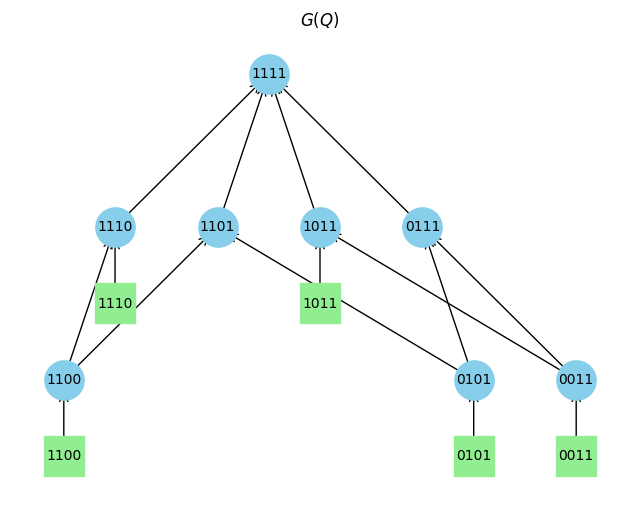

In [33]:
draw_G_K4(bugQ)

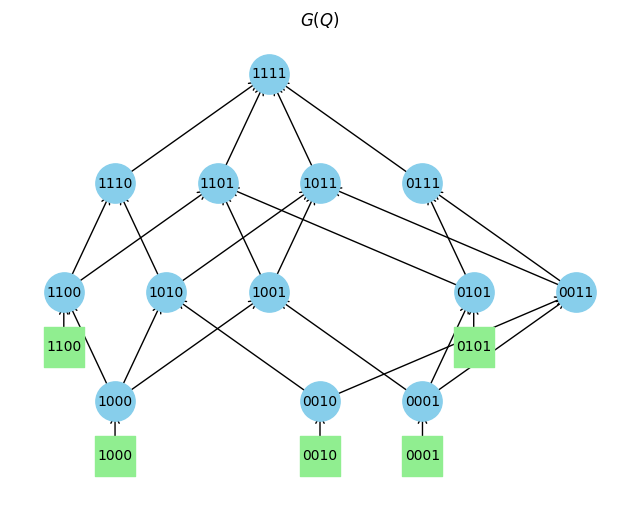

In [34]:
draw_G_K4(bugQbar)

In [ ]:
Q_basis

In [ ]:
solve_identifiability_Q_cpsat(Q_basis, Q_sorted)

In [ ]:
Q_sorted

In [ ]:
solve_Q_identifiability_debug(Q_sorted)

In [ ]:
Q_basis

In [ ]:
def add_lexico_constraints(model, x, J, K):
    """
    Enforce x[:,0] >=_lex x[:,1] >=_lex … >=_lex x[:,K-1]
    via first-difference indicators diff[k,i], i=0..J (i=J means 'no difference').
    
    - model : a Gurobi Model
    - x     : dict or 2D list of x[j,k] binary variables
    - J     : number of rows (items)
    - K     : number of columns (attributes)
    """
    # diff[k,i] = 1 if the *first* row where col k and k+1 differ is row i.
    # i in [0..J-1] covers each item; i=J means 'they never differ' (fully equal).
    diff = model.addVars(K-1, J+1, vtype=GRB.BINARY, name="diff")
    
    for k in range(K-1):
        # exactly one first-difference position
        model.addConstr(gp.quicksum(diff[k,i] for i in range(J+1)) == 1,
                        name=f"lex_sumdiff_{k}")
        
        # if they first differ at row i < J:
        for i in range(J):
            # all rows t < i must be equal:
            for t in range(i):
                model.addConstr(x[t,k] - x[t,k+1] <= 1 - diff[k,i],
                                name=f"lex_eq_above_{k}_{i}_{t}")
                model.addConstr(x[t,k+1] - x[t,k] <= 1 - diff[k,i],
                                name=f"lex_eq_above_rev_{k}_{i}_{t}")
            # at row i, enforce x[i,k]=1 and x[i,k+1]=0
            model.addConstr(x[i,k]     >= diff[k,i],
                            name=f"lex_diff1_{k}_{i}")
            model.addConstr(x[i,k+1] <= 1 - diff[k,i],
                            name=f"lex_diff2_{k}_{i}")
        
        # if no difference (i = J), all rows must be equal
        for t in range(J):
            model.addConstr(x[t,k] - x[t,k+1] <= 1 - diff[k,J],
                            name=f"lex_eq_nodiff_{k}_{t}")
            model.addConstr(x[t,k+1] - x[t,k] <= 1 - diff[k,J],
                            name=f"lex_eq_nodiff_rev_{k}_{t}")

In [ ]:
def solve_Q_identifiability_debug(Q, startQ = None):
    J, K = Q.shape

    # Step 1: Generate constraints Phi_a based on Q
    Phi = list(unique_response_columns(Q))
    A = len(Phi)  # number of unique response vectors

    # Step 2: Set up the integer program
    model = gp.Model('Q_identifiability')
    model.setParam('SolutionLimit', 1)
    model.setParam('OutputFlag', 1)

    # Decision variables
    x = model.addVars(J, K, vtype=GRB.BINARY, name="x")     # for \bQQ
    h = model.addVars(A, K, vtype=GRB.BINARY, name="h")     # for h(a)
    # start with x = Q (feasible for C1 but violates C2) – useful branching guide
    if startQ is not None:
        for j,k in np.ndindex(Q.shape):
            x[j,k].Start = startQ[j,k]
    # Norm constraints, together with the column ordering constraint. Slower than the unproved version "\bqq_j \preceq \qq_j".
    
    # --- norm constraints ------------------------------
    dist = distances(Q)
    for j in range(J):
        model.addConstr(gp.quicksum(x[j, k] for k in range(K)) <= K - dist[j])
        model.addConstr(1 <= gp.quicksum(x[j, k] for k in range(K)))
        
    # --- column lex‑ordering constraints ------------------------------
    # pow2 = [1 << (J - 1 - j) for j in range(J)]   # 2^{J-j-1}
    # def column_code(k):
    #     return gp.quicksum(pow2[j] * x[j, k] for j in range(J))
    # for k in range(K - 1):
    #     model.addConstr(column_code(k) >= column_code(k + 1),
    #                     name=f"lex_col_{k}") 
    # add_lexico_constraints(model, x, J, K)
        
    # Non-equality constraint to ensure \bQQ ≠ \QQ
    model.addConstr(
        gp.quicksum(
            (1 - Q[j, k]) * x[j, k]         # q=0  →  uses x
            + Q[j, k]    * (1 - x[j, k])    # q=1  →  uses 1-x
            for j in range(J)
            for k in range(K)
        ) >= 1,name="Q != Q_bar")

    # Constraints to define h[a,k] = ⋁_{j in S_a} x[j,k]
    for a, phi_a in enumerate(Phi):
        S_a = [j for j in range(J) if phi_a[j] == 1]
        for k in range(K):
            for j in S_a:
                model.addConstr(h[a, k] >= x[j, k], name=f"h_lb_a{a}_j{j}_k{k}")
            model.addConstr(h[a, k] <= gp.quicksum(x[j, k] for j in S_a), name=f"h_ub_a{a}_k{k}")

    # Non-domination constraint: h(a) ≰ \bqq_j for all j not in S_a
    for a, phi_a in enumerate(Phi):
        not_S_a = [j for j in range(J) if phi_a[j] == 0]
        for j in not_S_a:
            model.addConstr(
                gp.quicksum((1 - h[a, k]) * x[j, k] for k in range(K)) >= 1,
                name=f"non_dom_a{a}_j{j}"
            )

        
    # Solve the integer program
    model.optimize()
    status = model.Status

    if status == GRB.INFEASIBLE:
        return None                         # Q identifiable
    elif status in (GRB.OPTIMAL, GRB.SOLUTION_LIMIT):
        solution = np.array([[int(x[j, k].X) for k in range(K)] for j in range(J)])
        return solution  # Q is not identifiable
    elif status == GRB.SUBOPTIMAL:
        if model.SolCount > 0:
            solution = np.array([[int(x[j, k].X) for k in range(K)] for j in range(J)])
            return solution
        else:
            return None  # inconclusive — could trigger Phase B
    else:
        return None      # early termination (time limit, etc.)


In [ ]:
solve_Q_identifiability_debug(Q_sorted)

In [ ]:
solve_Q_identifiability_debug(Q_sorted)

In [ ]:
solve_Q_identifiability_debug(Q_sorted)

In [ ]:
unique_response_columns(Q_sorted)

In [ ]:
unique_response_columns(Q_sorted).issubset(unique_response_columns(Qstart))

In [30]:
def thm_check(Q: np.ndarray, Q_bar: np.ndarray) -> bool:
    """
    Return True  iff  Cols[Φ(Q)] ⊆ Cols[Φ(Q̄)],
    i.e. the non-domination test of your theorem is satisfied.
    """
    J, K = Q.shape
    assert Q_bar.shape == (J, K), "Q and Q_bar must have the same dimensions"

    Phi = unique_response_columns(Q)          # list of 0/1 length-J vectors

    # Pre-compute rows of Q̄ for convenience
    bq = Q_bar.astype(np.uint8)

    # For every φ_a ∈ Φ(Q) ───────────────────────────────────────────────
    for phi_a in Phi:
        S_a      = np.where(phi_a == 1)[0]    # indices with φ_a[j] = 1
        not_S_a  = np.where(phi_a == 0)[0]    # the complement

        # h_a  =  bitwise OR of rows bq_j for j ∈ S_a
        if len(S_a) == 1:
            h_a = bq[S_a[0]].copy()
        else:
            h_a = np.bitwise_or.reduce(bq[S_a], axis=0)

        # Check non-domination for every j ∉ S_a
        # h_a ⪰ bq_j  ⇔  (h_a ≥ bq_j) componentwise
        for j in not_S_a:
            if np.all(h_a >= bq[j]):          # domination ⇒ theorem violated
                return False

    return True


In [ ]:
thm_check(Q,Q_bar)

In [48]:
J = 6
K = 5

In [49]:
all_matrices = generate_canonical_matrices(J = J, K = K)
len(all_matrices)

11074

<!-- ###  A topological sort is a nonunique permutation of the nodes such that an edge from u to v implies that u appears before v in the topological sort order. -->

In [ ]:
len(generate_canonical_matrices(5, 4))

In [ ]:
len(generate_canonical_matrices(6, 4))

In [ ]:
len(generate_canonical_matrices(7, 4))

Q_basis with dimensions J < K, thus not identifiable.
Q_basis with dimensions J < K, thus not identifiable.
Q_basis with dimensions J < K, thus not identifiable.
Q_basis with dimensions J < K, thus not identifiable.
Q_basis with dimensions J < K, thus not identifiable.
Q_basis with dimensions J < K, thus not identifiable.
Q_basis with dimensions J < K, thus not identifiable.
Q_basis with dimensions J < K, thus not identifiable.
Q_basis with dimensions J < K, thus not identifiable.
Q_basis with dimensions J < K, thus not identifiable.
Q_basis with dimensions J < K, thus not identifiable.
Q_basis with dimensions J < K, thus not identifiable.
Q_basis with dimensions J < K, thus not identifiable.
Q_basis with dimensions J < K, thus not identifiable.
Q_basis with dimensions J < K, thus not identifiable.
Q_basis with dimensions J < K, thus not identifiable.
Q_basis with dimensions J < K, thus not identifiable.
Q_basis with dimensions J < K, thus not identifiable.
Q_basis with dimensions J < 

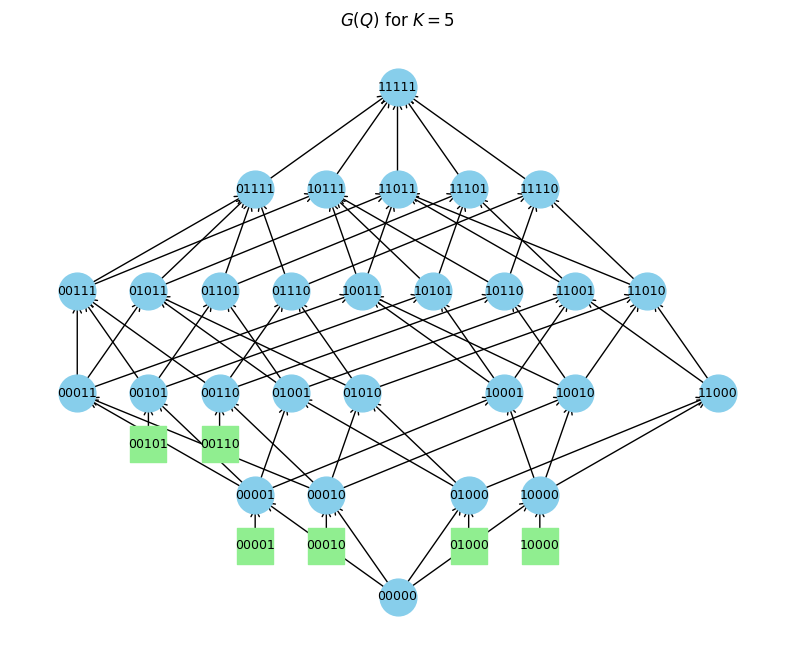

Q is not identifiable (two-column submatrix not identifiable).


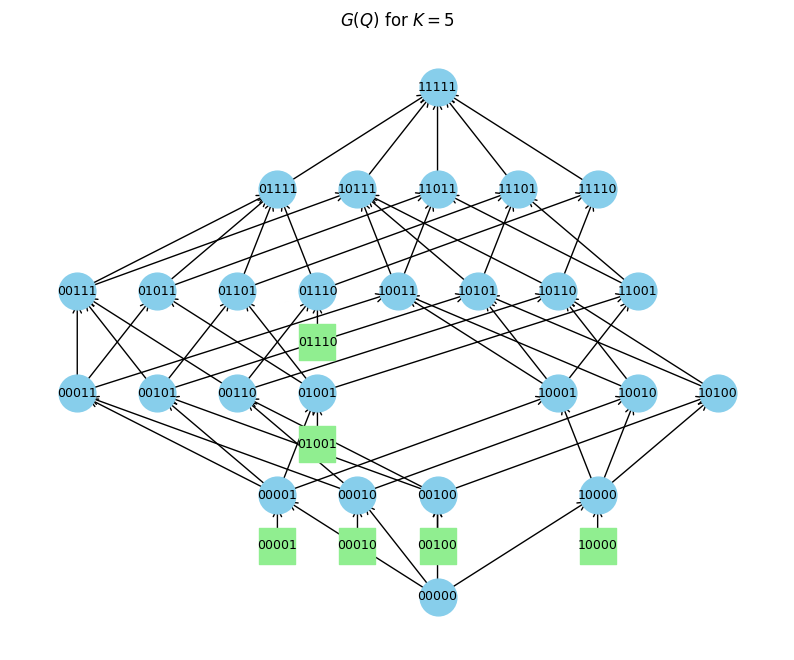

Q is not identifiable (two-column submatrix not identifiable).


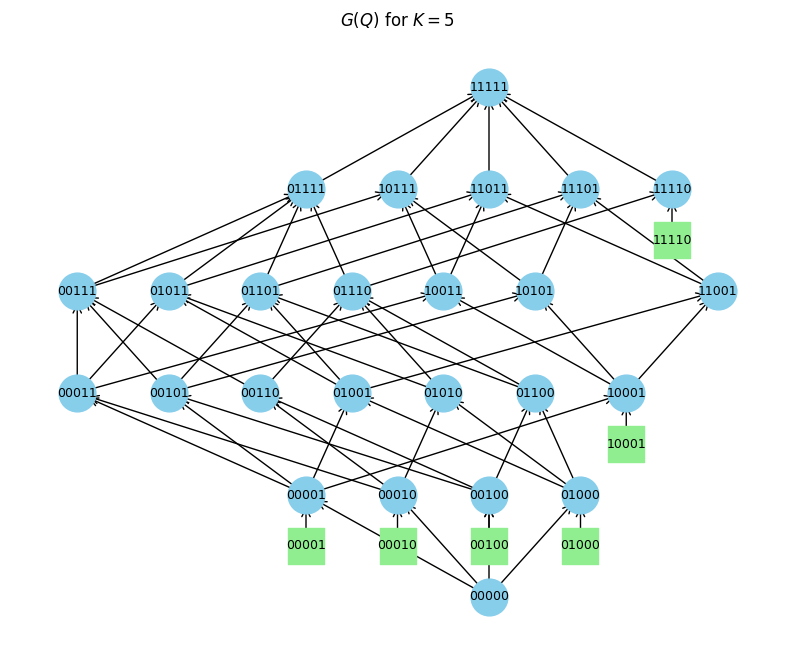

Q is not identifiable (two-column submatrix not identifiable).


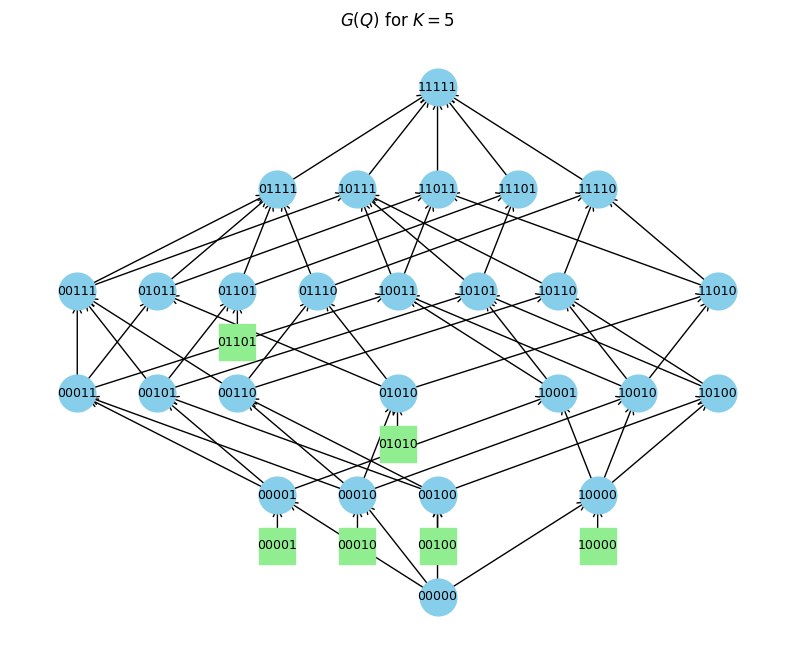

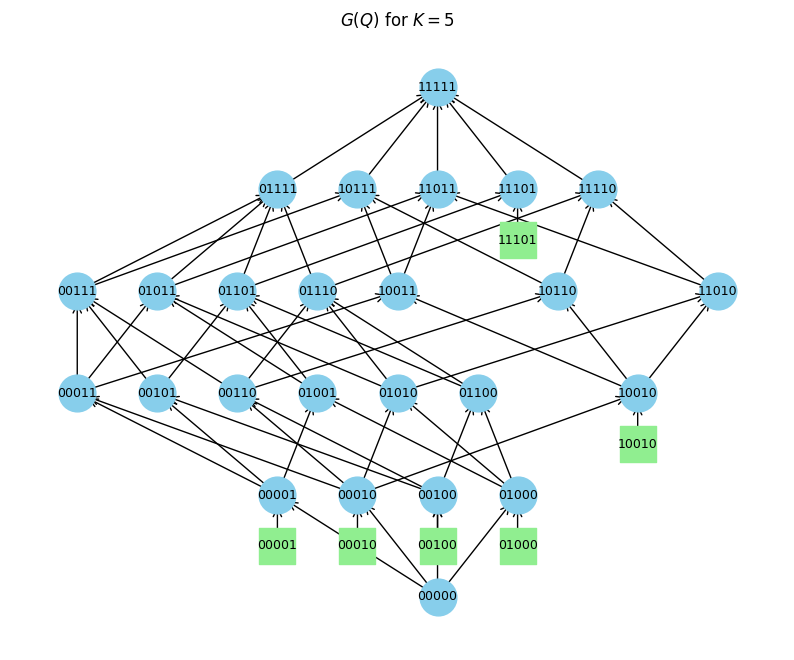

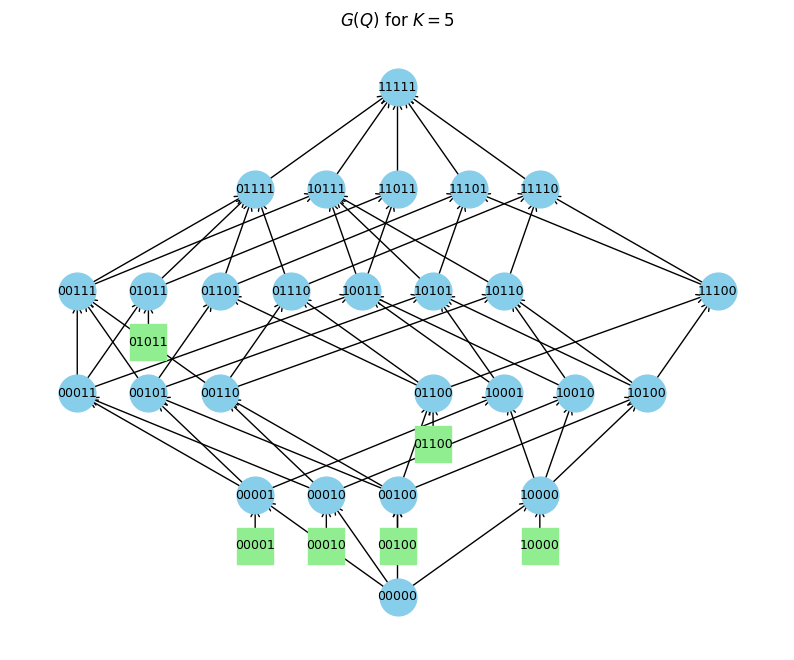

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).


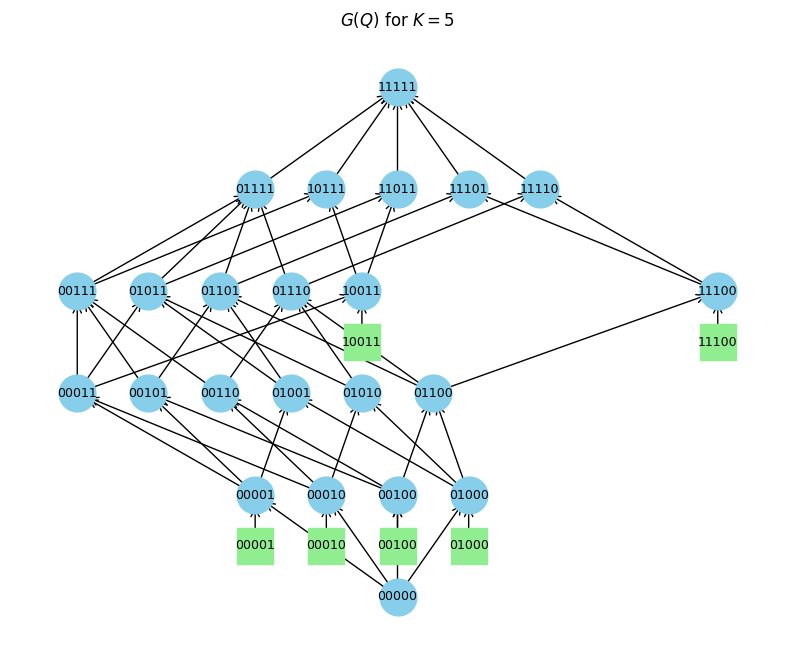

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).


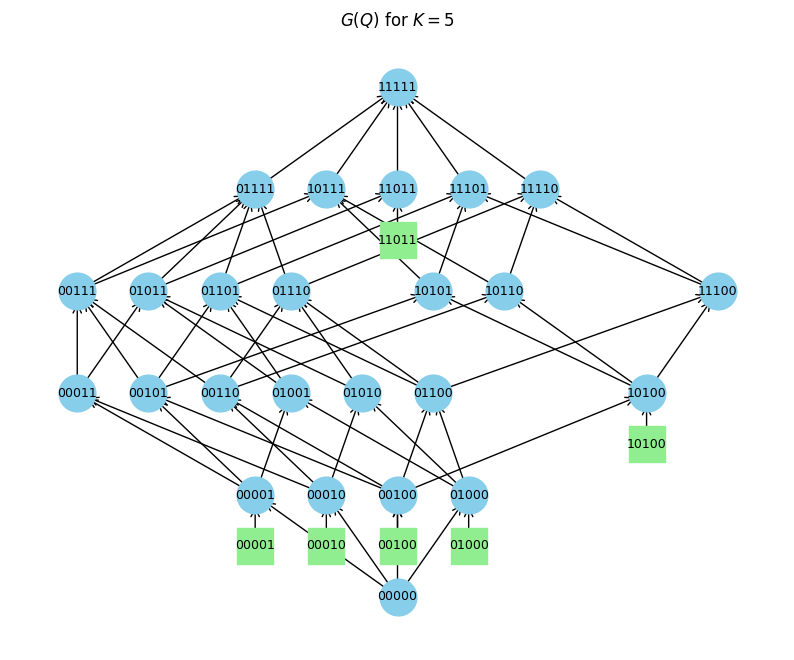

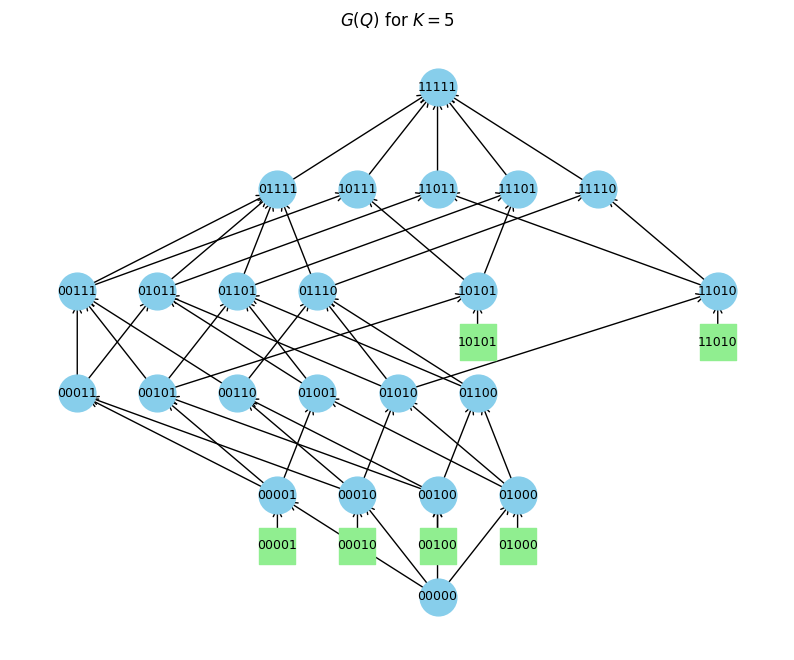

Q is not identifiable (two-column submatrix not identifiable).


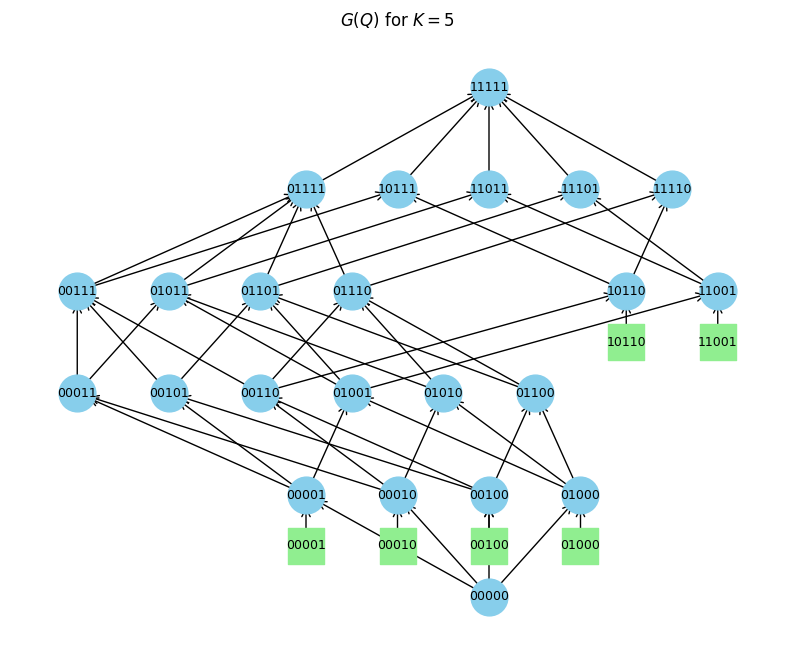

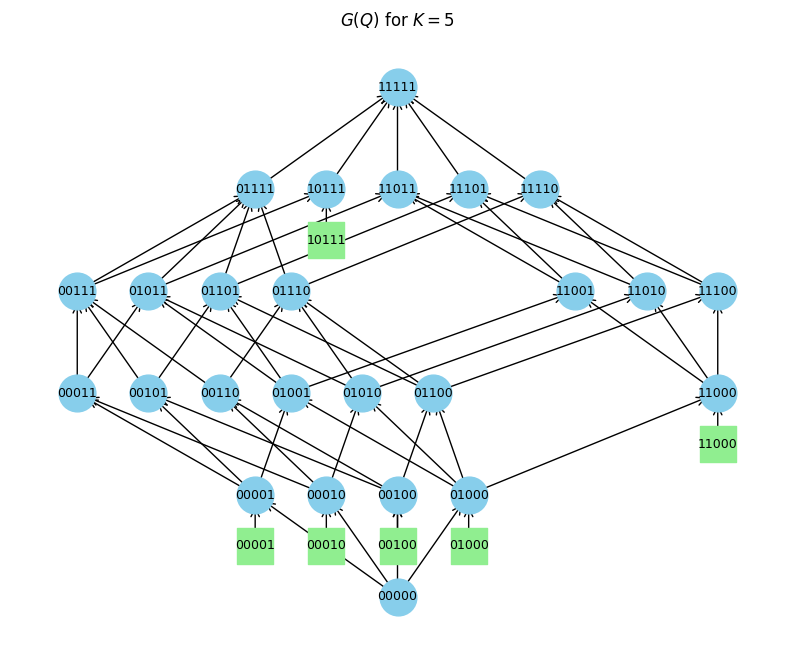

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is trivially not identifiable (all zero column).
Q is trivially not identifiable (all zero column).
Q is trivially not identifiable (all zero column).
Q is trivially not identifiable (all zero column).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submat

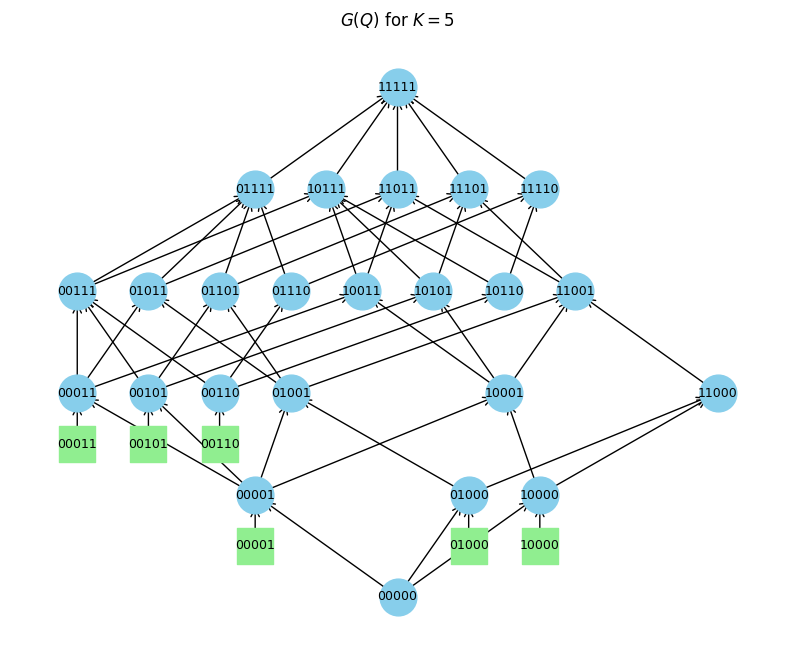

Q is not identifiable (two-column submatrix not identifiable).


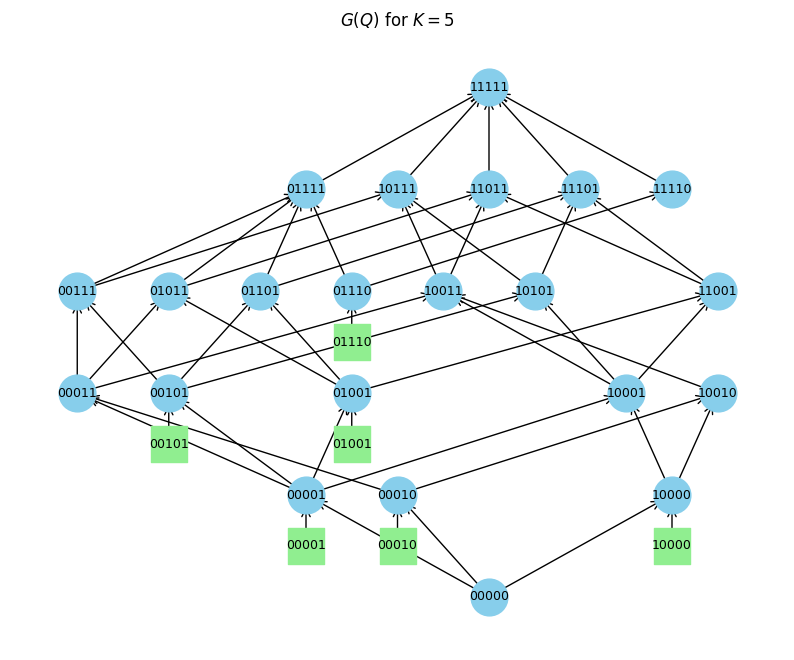

Q is not identifiable (two-column submatrix not identifiable).


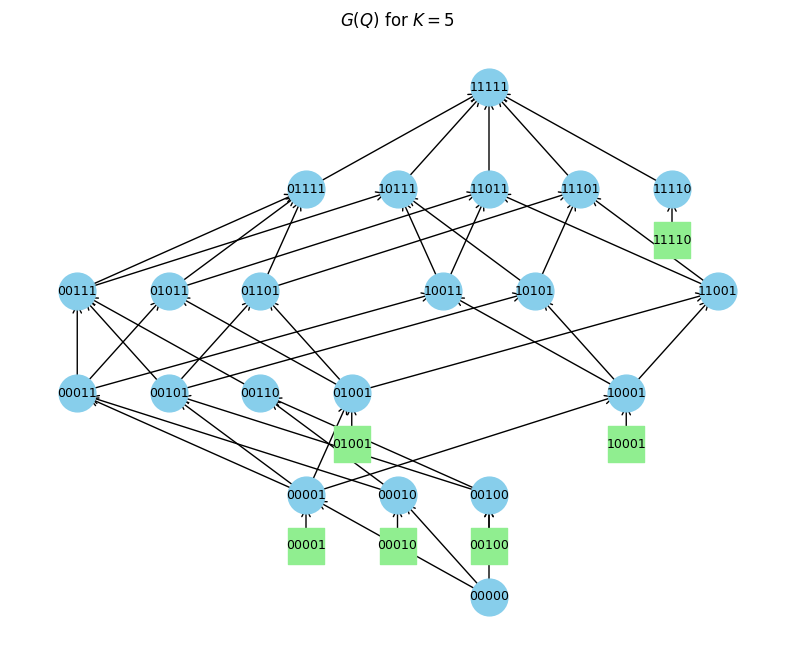

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).


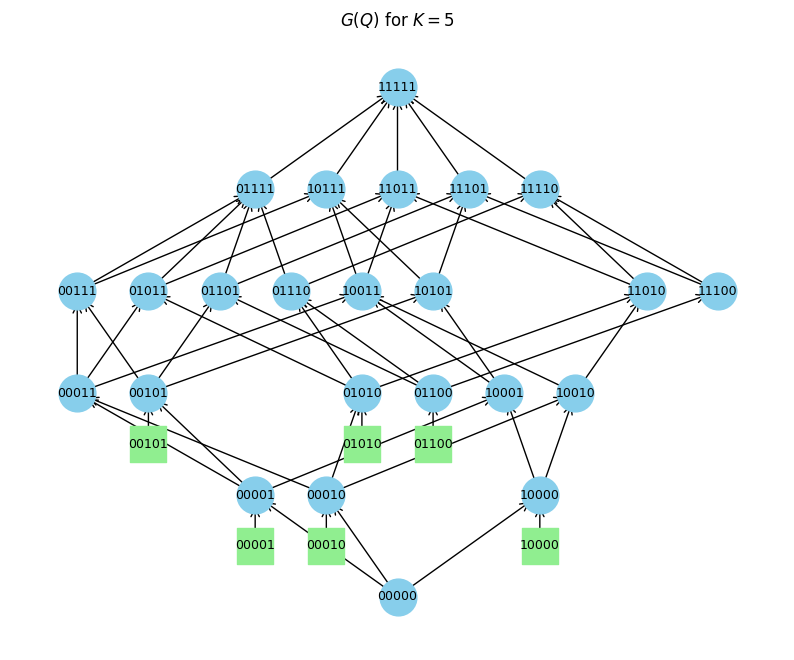

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).


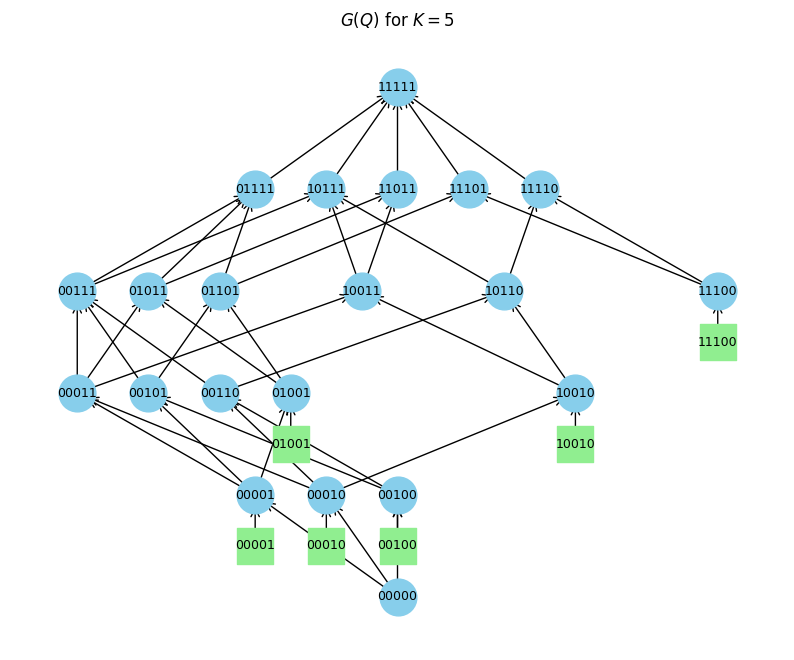

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).


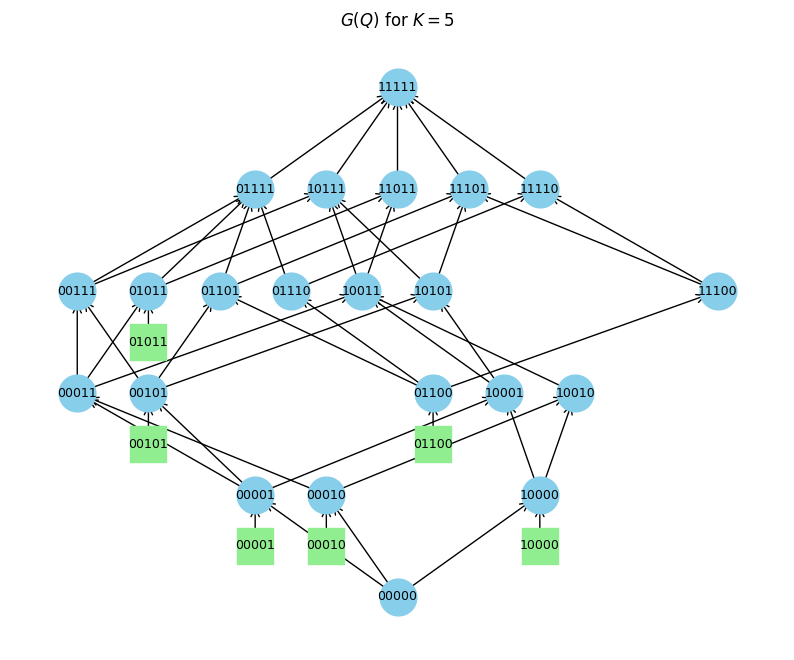

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).


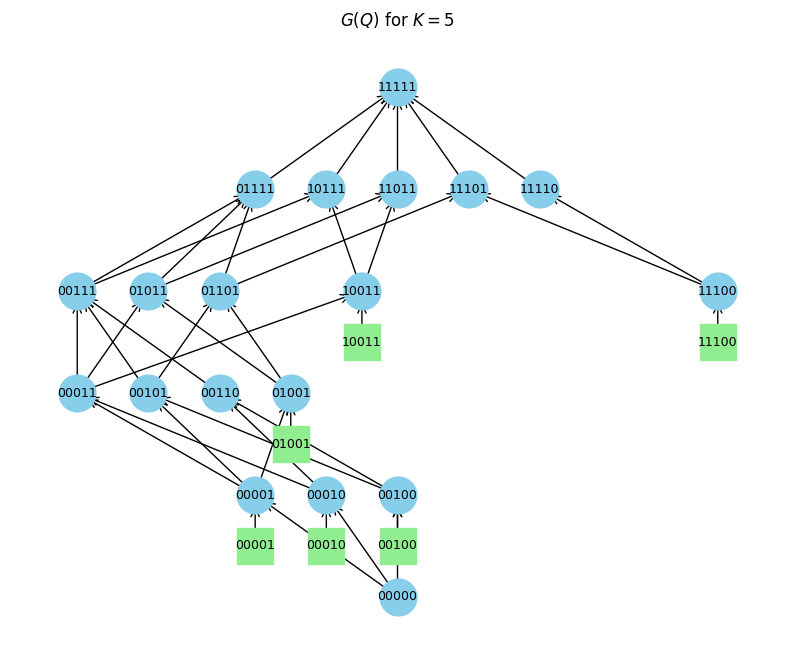

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).


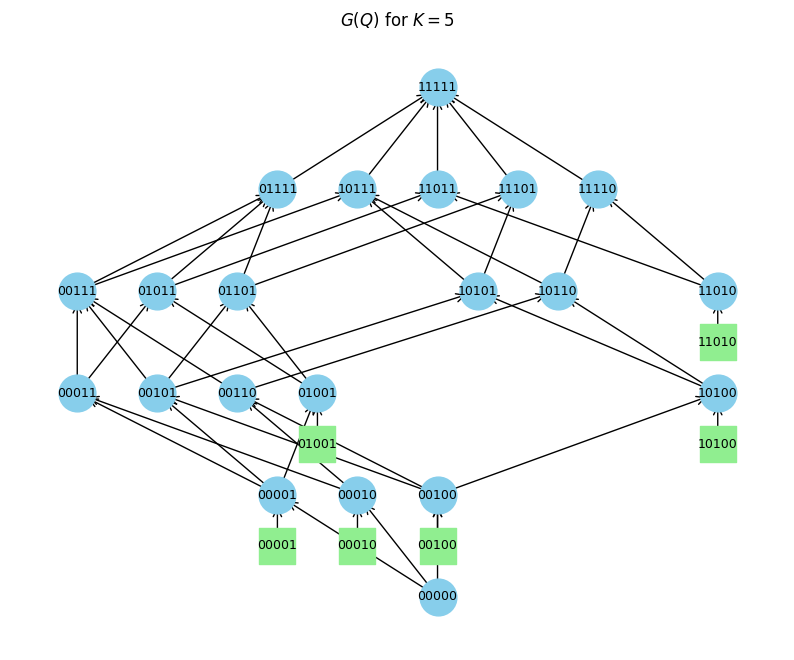

Q is not identifiable (two-column submatrix not identifiable).


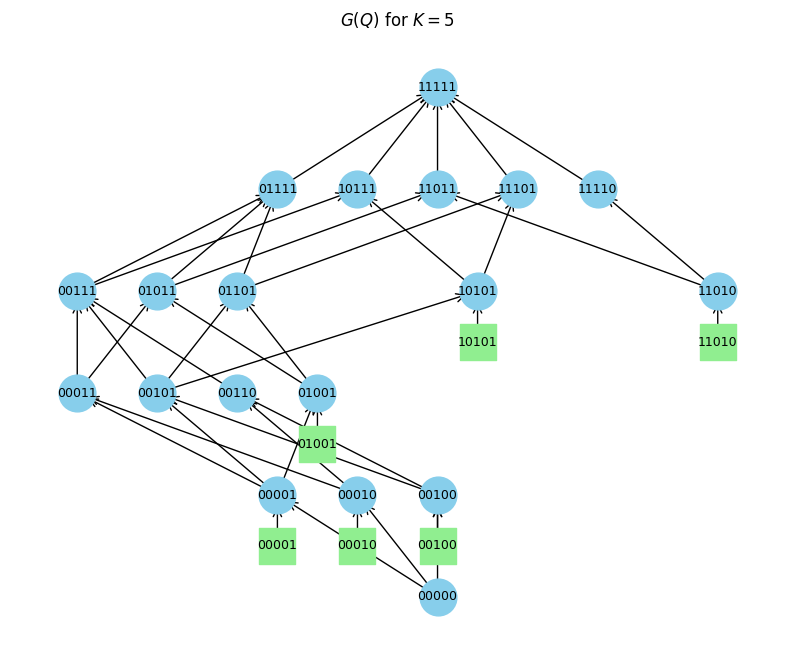

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).


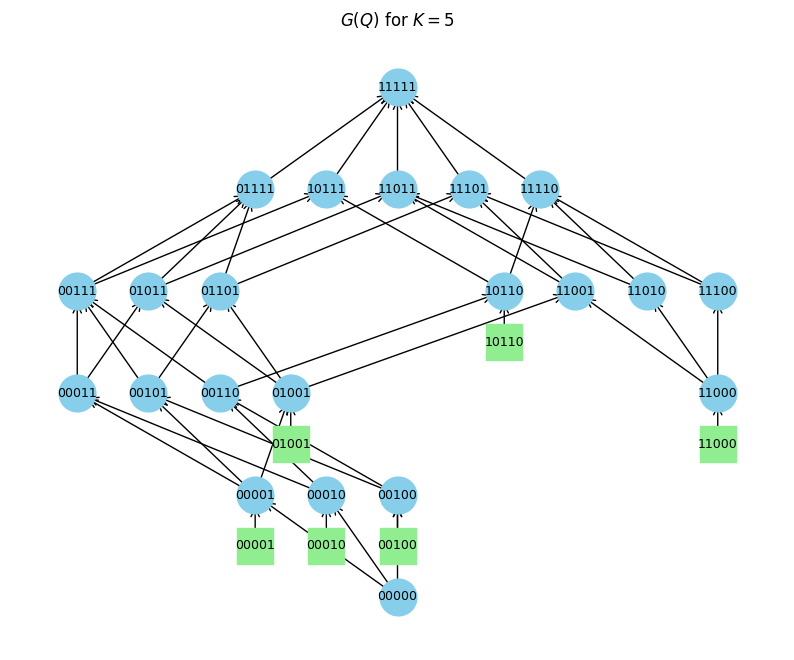

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).


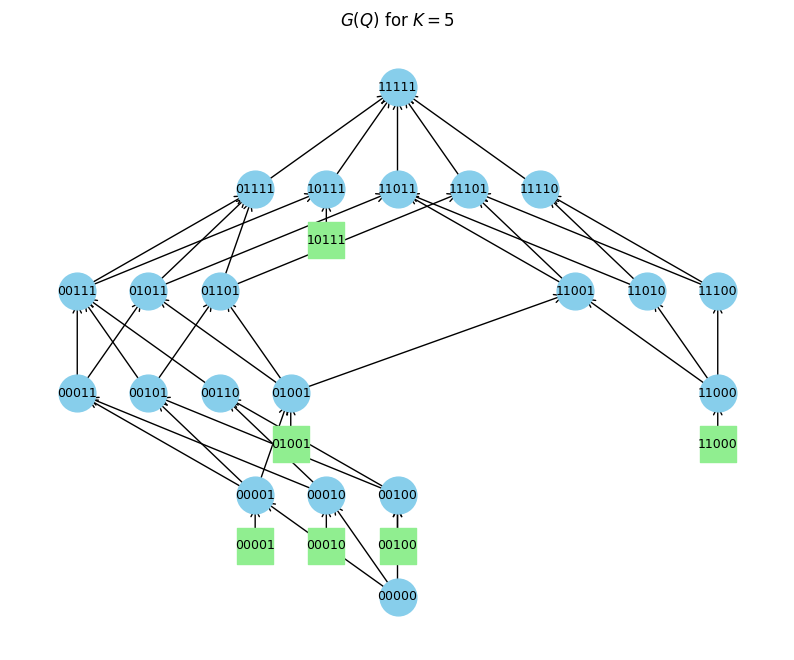

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identif

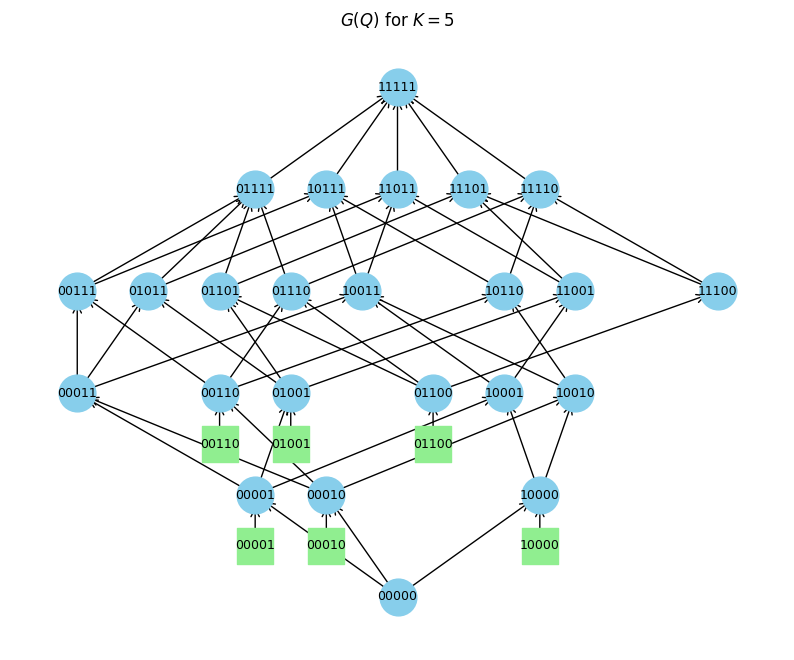

Q is not identifiable (two-column submatrix not identifiable).


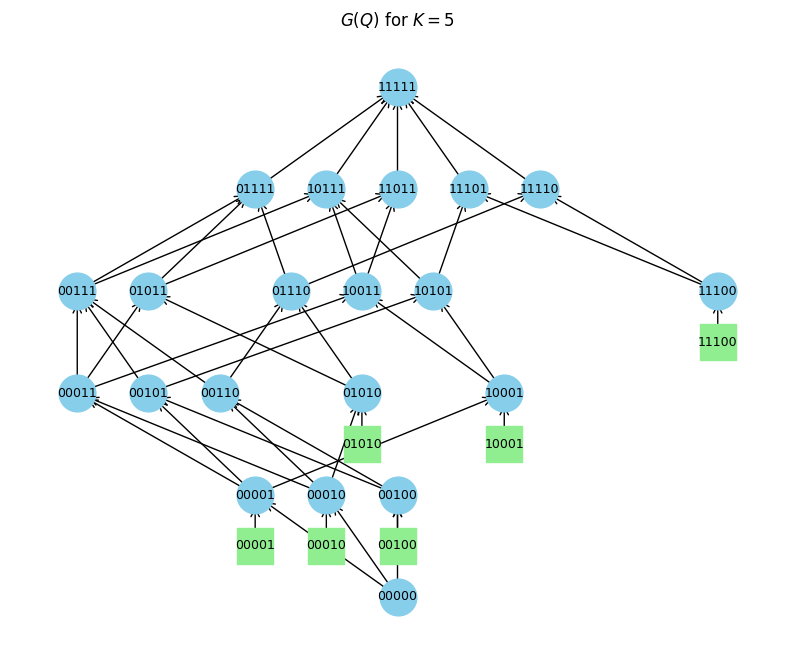

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).


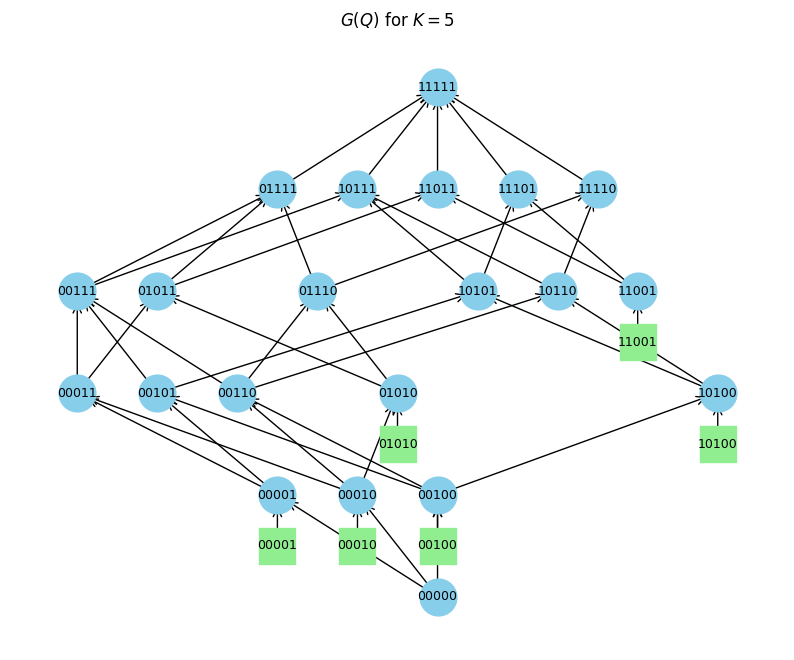

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).


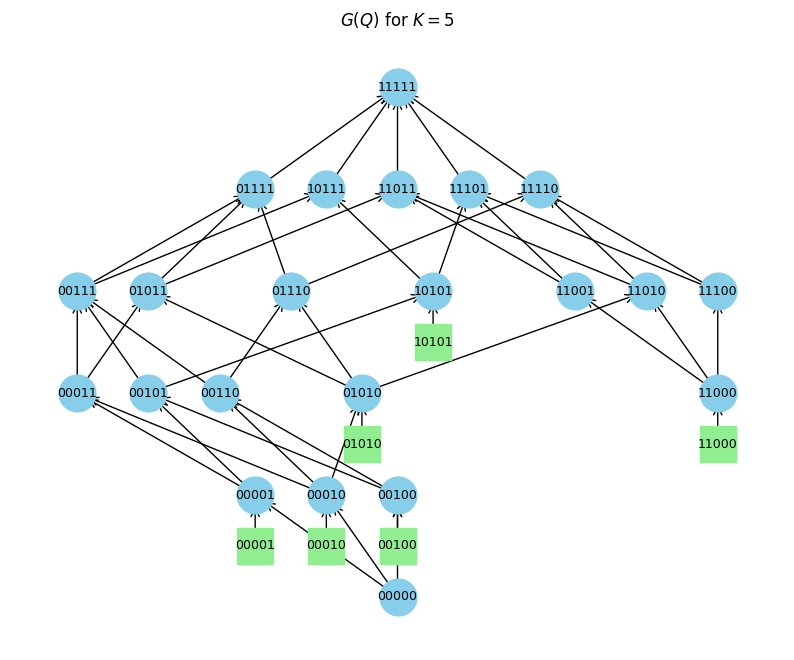

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is trivially not identifiable (all zero column).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is

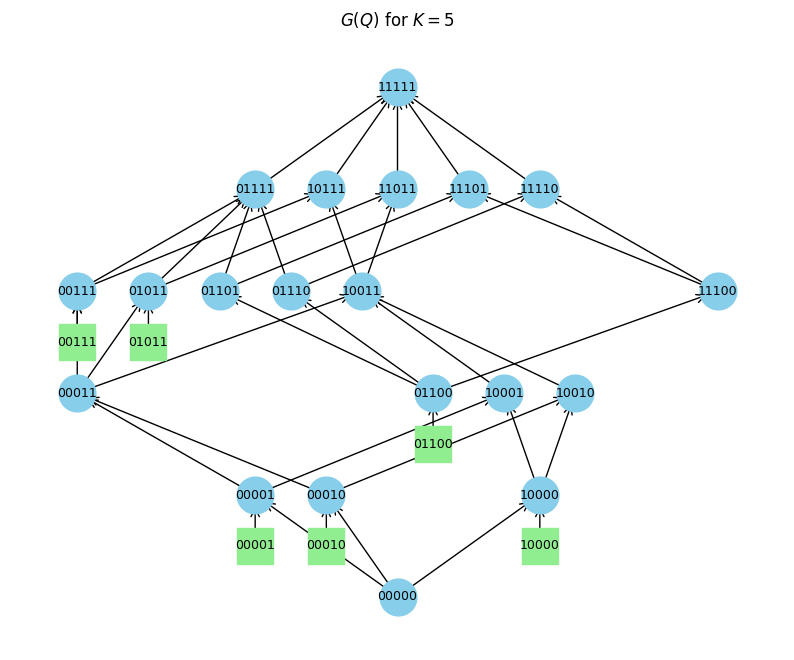

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).


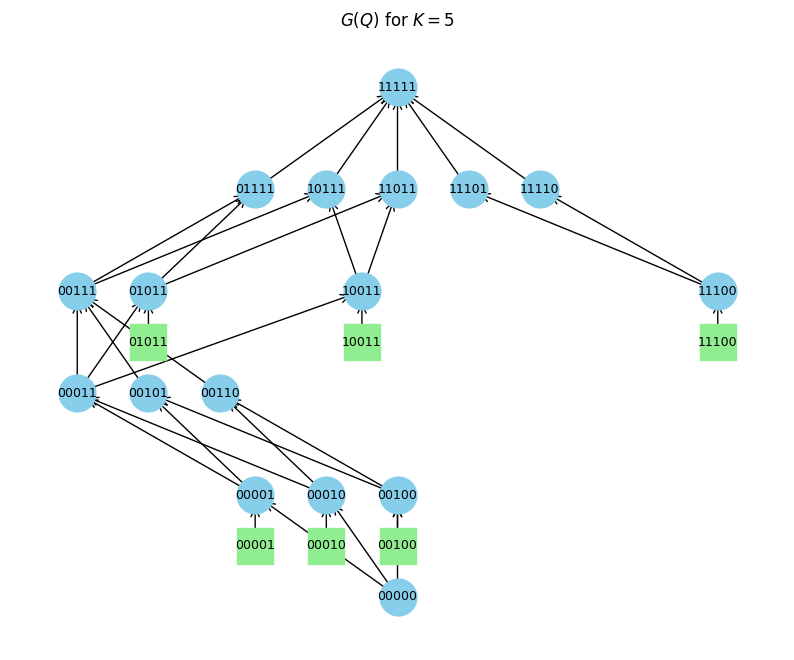

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).


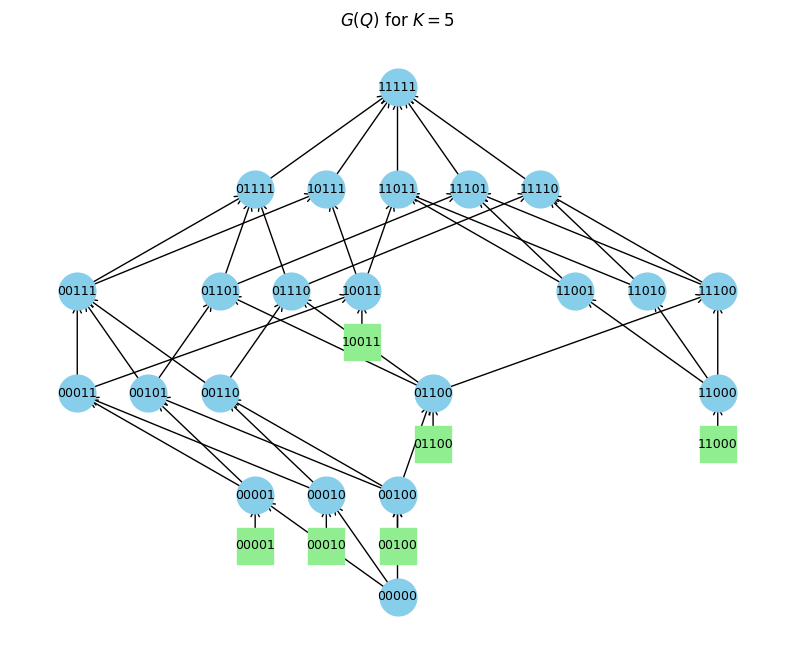

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).


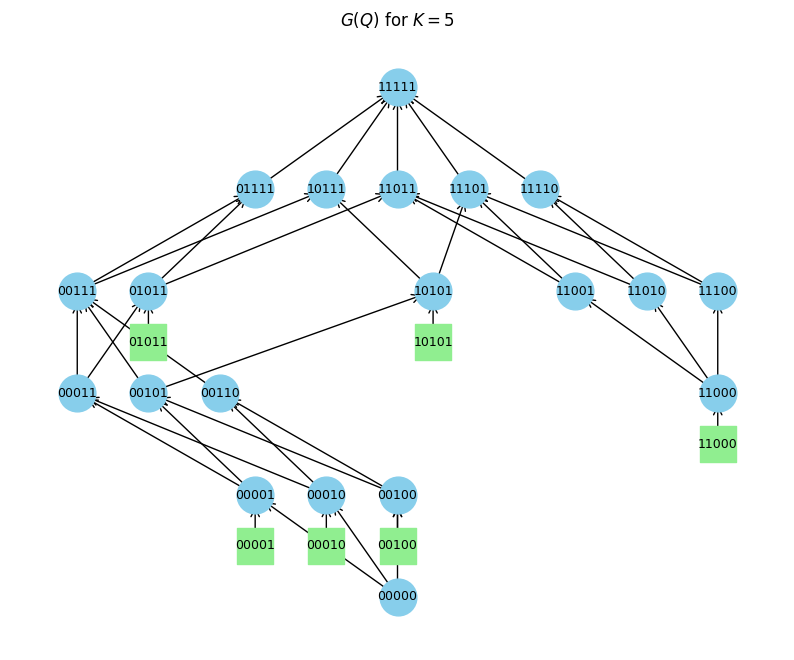

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).


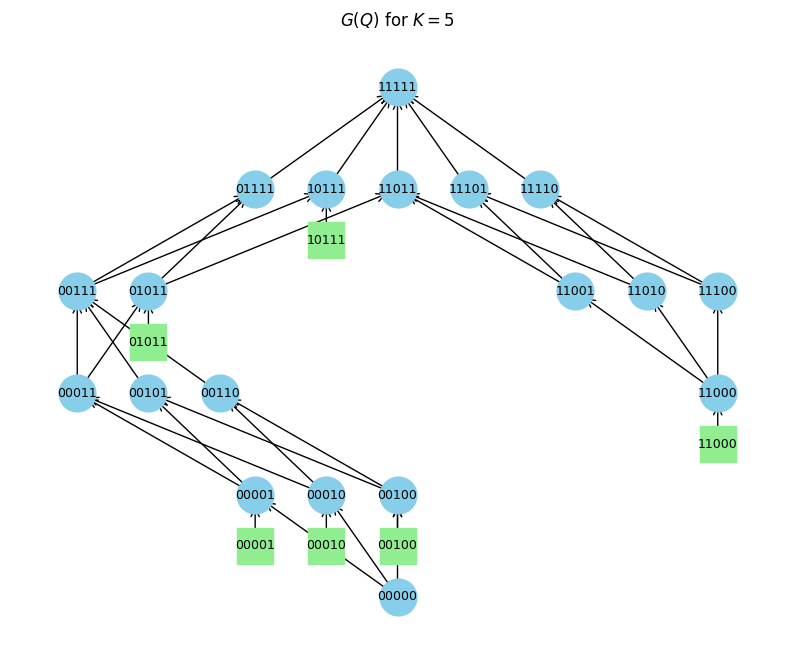

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identif

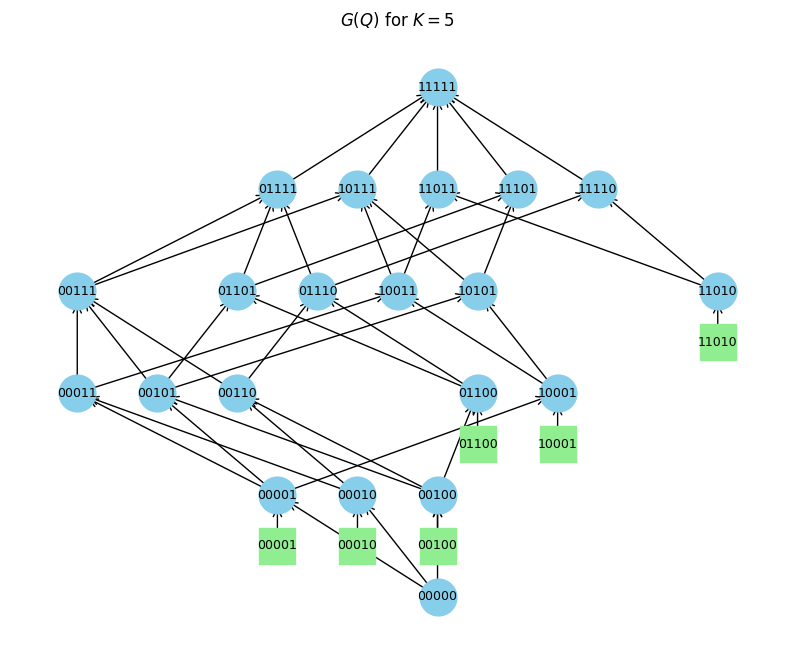

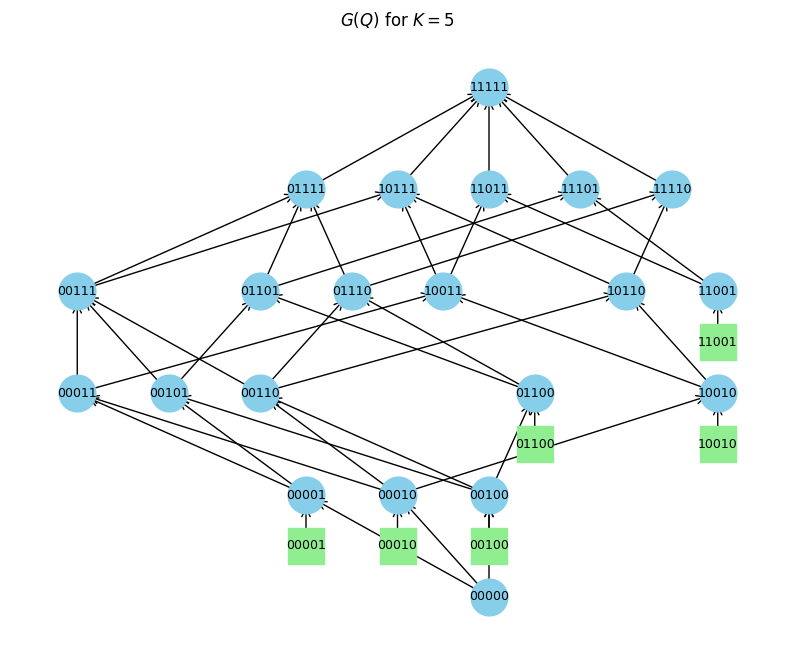

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).


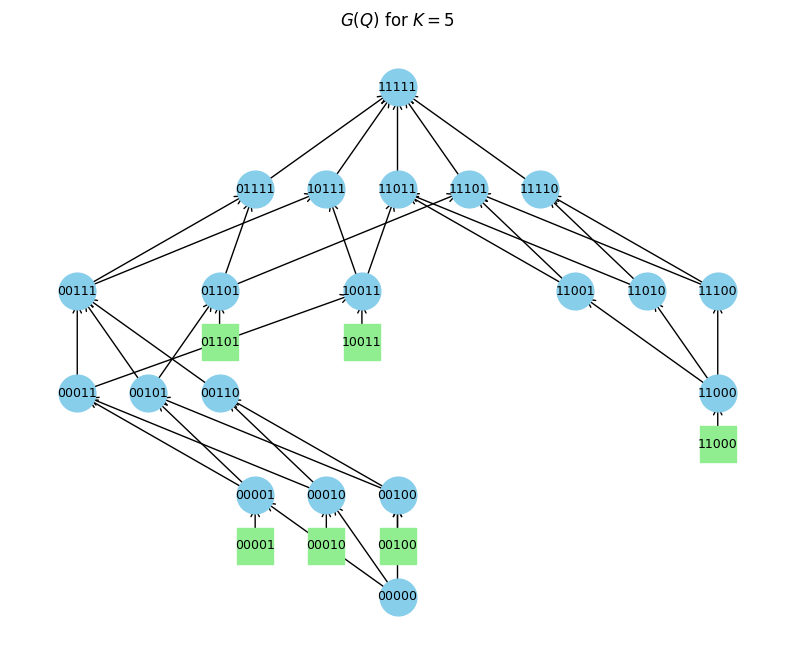

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identif

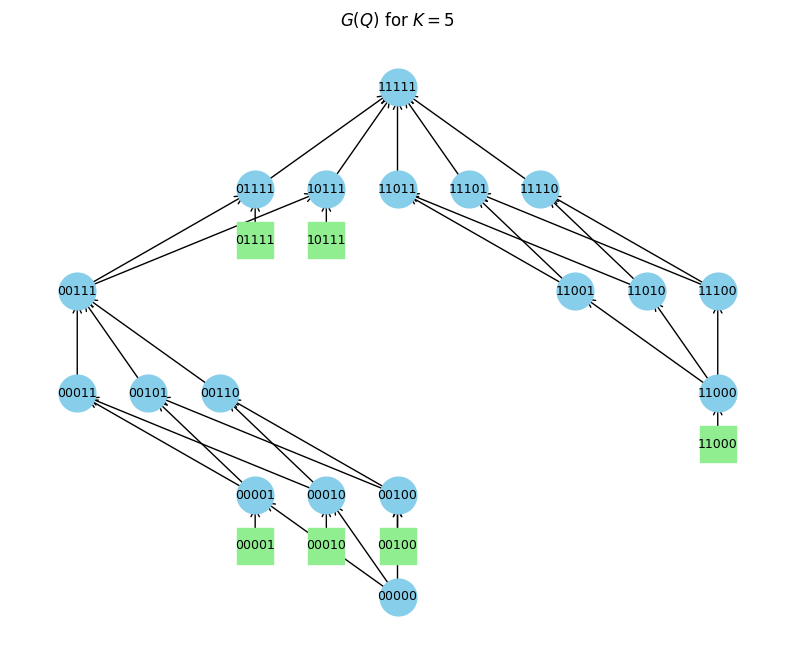

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q_basis with dimensions J < K, thus not identifiable.
Q_basis with dimensions J < K, thus not identifiable.
Q_basis wi

In [50]:
id_Q65 = []
id_Q65_withoutI = []
nid_Q65_id2 = []
nid_Q65_id3 = []
nid_Q65_ncol = []
for Q in all_matrices[:1000]:
    idd, Q_bar = identifiability_debug(Q = Q)
    if idd:
        id_Q65.append(Q)
        if not contains_identity_submatrix(Q):
            id_Q65_withoutI.append(Q)
            draw_G_K5(Q)

In [52]:
len(id_Q65)

39

In [51]:
len(id_Q65_withoutI)

35

In [ ]:
id_Q65 = []
id_Q65_withoutI = []
nid_Q65_id2 = []
nid_Q65_id3 = []
nid_Q65_ncol = []
for Q in all_matrices[:1000]:
    idd, Q_bar = identifiability2(Q = Q)
    if idd:
        id_Q65.append(Q)
        if not contains_identity_submatrix(Q):
            id_Q65_withoutI.append(Q)
            draw_G_K5(Q)

In [ ]:
len(id_Q65)

In [ ]:
idx = 0
for Q in id_Q65_withoutI:
    idx += 1
    print(idx)
    draw_G_K5(Q)
    

In [ ]:
import numpy as np

result = []
for Q in id_Q65_withoutI:
    # Get the set of representative node rows and the set of current item node rows
    R_Q = representative_node_set(Q)
    I_Q = item_node_set(Q)
    # Determine which representative rows are not already present in Q
    new_rows = R_Q - I_Q
    for q in new_rows:
        # Create a new Q by appending q to Q.
        # We first convert each row of Q to a list of integers (binary values)
        newQ_list = [list(map(int, row)) for row in Q]
        # Convert the candidate row q to a list of integers
        new_row = list(map(int, q))
        newQ_list.append(new_row)
        # Convert newQ_list to a NumPy array with integer type to ensure it's a binary matrix
        newQ = np.array(newQ_list, dtype=int)
        # Check if newQ is non-identifiable
        if not identifiability(newQ):
            # Optionally, you might want to store the original Q as a binary matrix too
            result.append((np.array(Q, dtype=int), newQ))


In [ ]:
result

# Generate all identifiable Q that does not contain an identity.

## id_Q54_withoutI: identifiable Q without Identity matrix.
## nid_Q54_id2: Not identifiable Q that satisfies: any two columns contain an I.

Q_basis with dimensions J < K, thus not identifiable.
Q_basis with dimensions J < K, thus not identifiable.
Q is identifiable (direct_check).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is trivially not identifiable (all zero column).
Q_basis with dimensions J < K, thus not identifiable.
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable

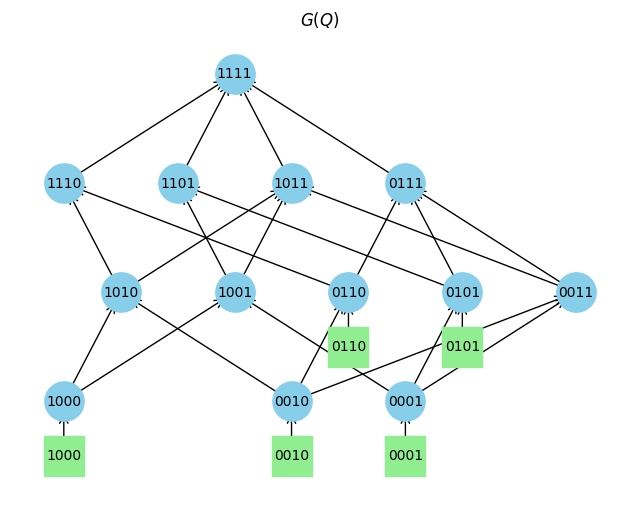

Q is not identifiable (two-column submatrix not identifiable).


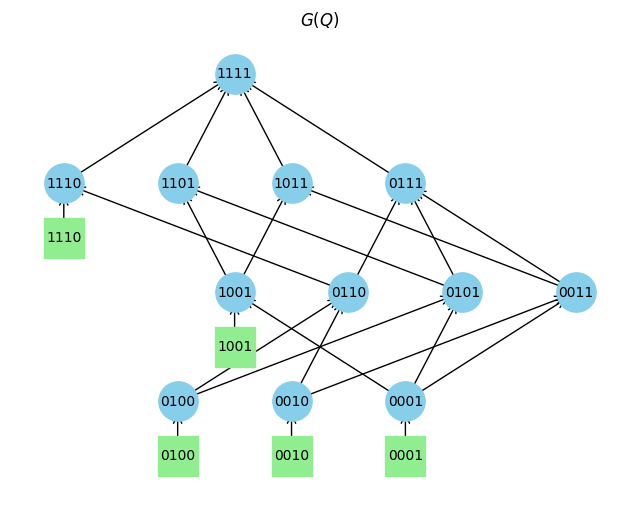

Q is not identifiable (two-column submatrix not identifiable).


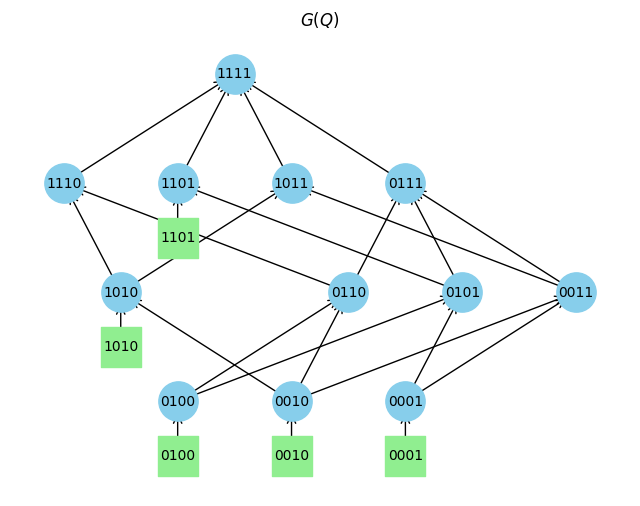

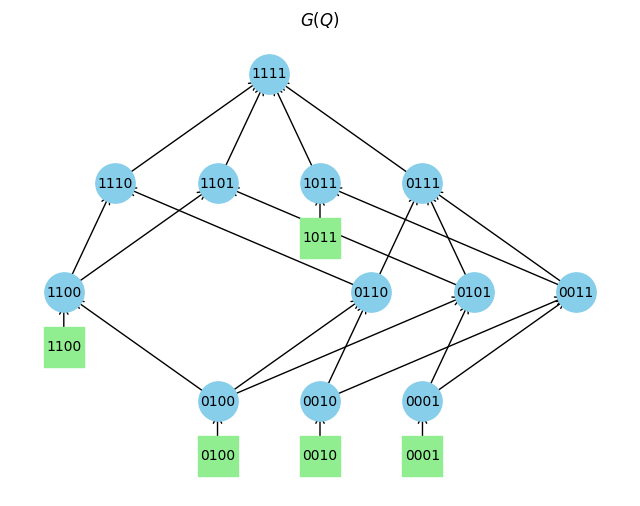

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is trivially not identifiable (all zero column).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).


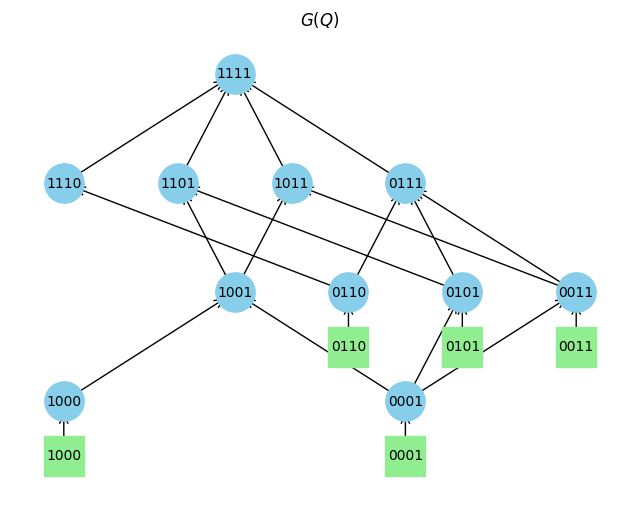

Q is not identifiable (two-column submatrix not identifiable).


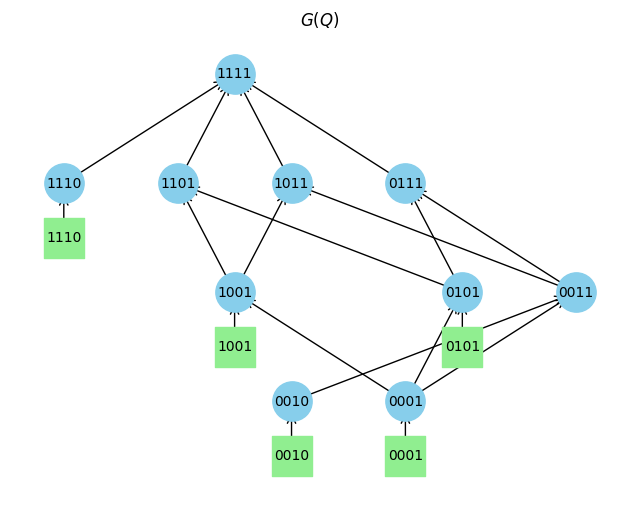

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).


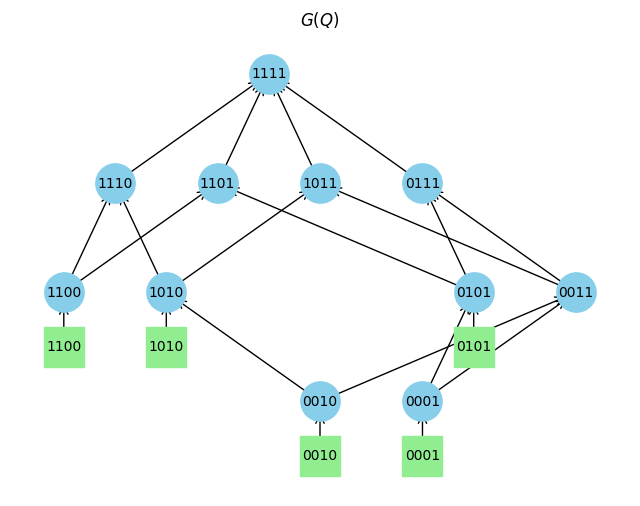

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).


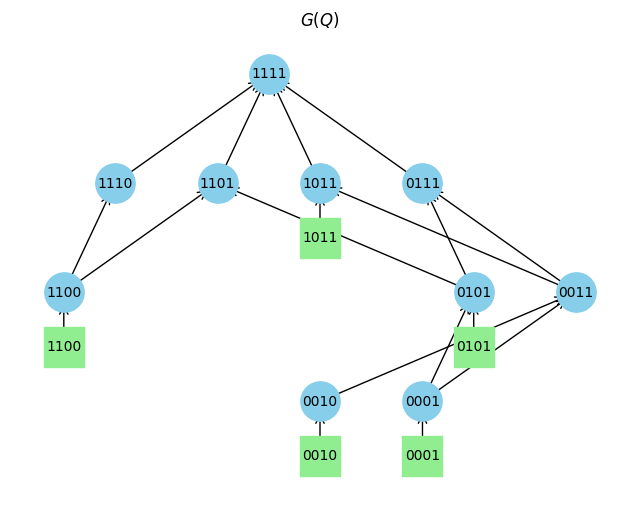

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).


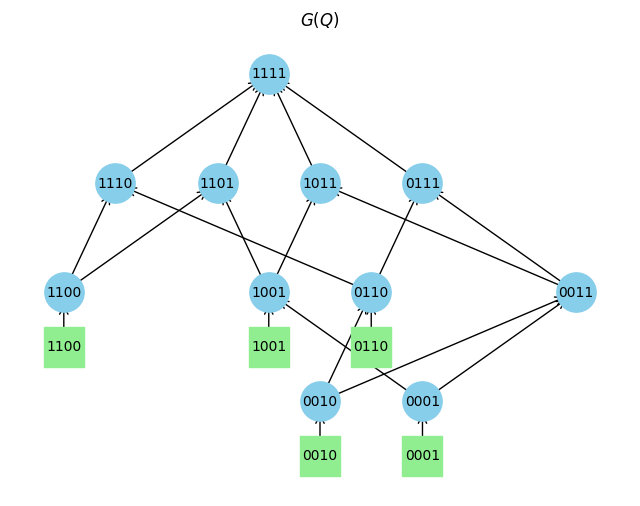

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).


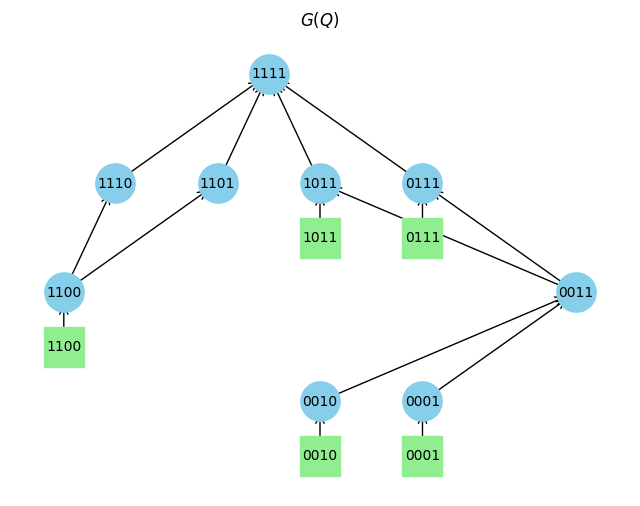

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q_basis with dimensions J < K, thus not identifiable.
Q_basis with dimensions J < K, thus not identifiable.
Q is not identifiable (two-column submatrix not identifiable).
Q is trivially not identifiable (all zero column).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is trivially not identifiable (all one column).
Q is not identifiable (two-column s

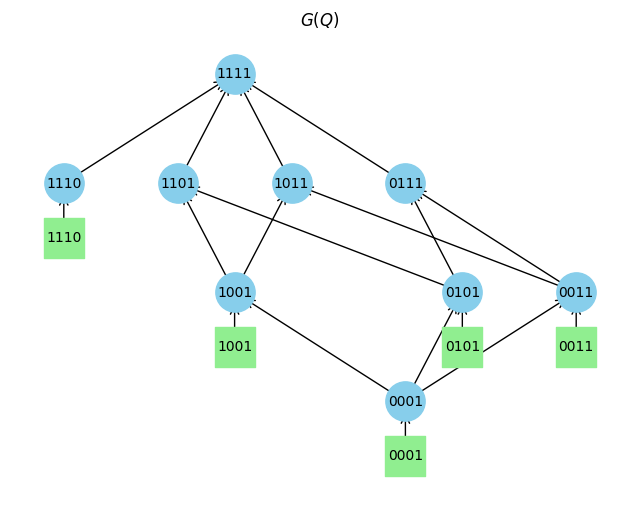

Q is trivially not identifiable (all one column).
Q is not identifiable (two-column submatrix not identifiable).


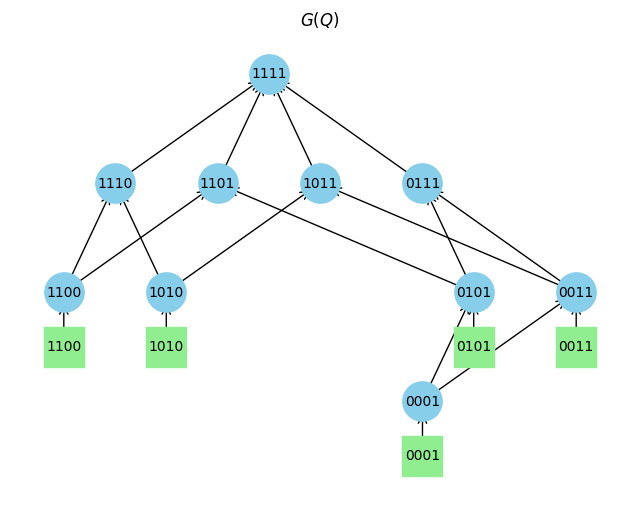

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is trivially not identifiable (all one column).
Q is not identifiable (two-column submatrix not identifiable).
Q is trivially not identifiable (all one column).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).


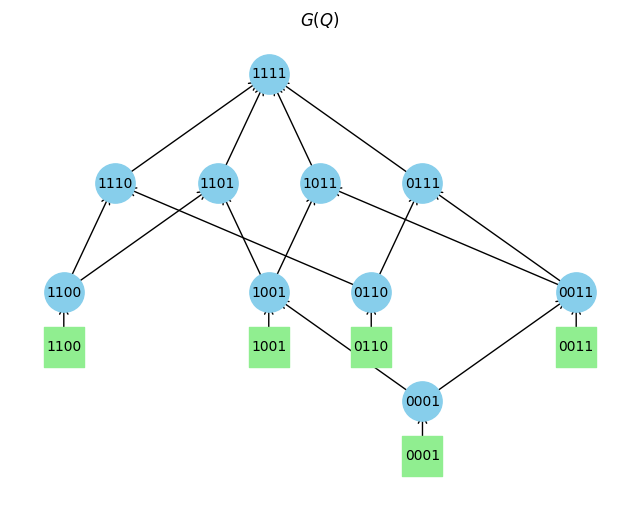

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).


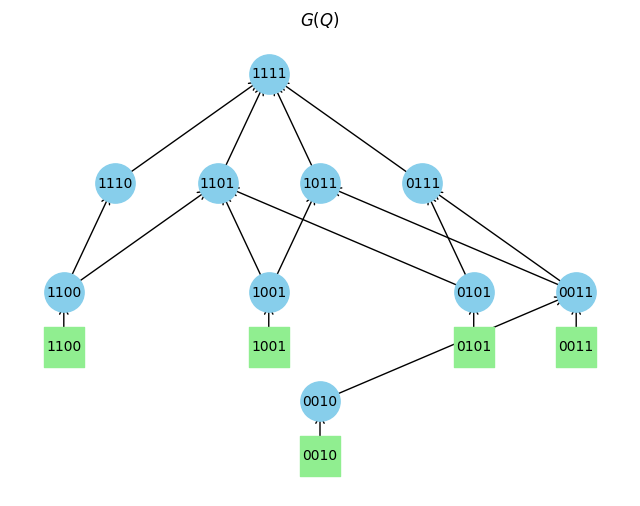

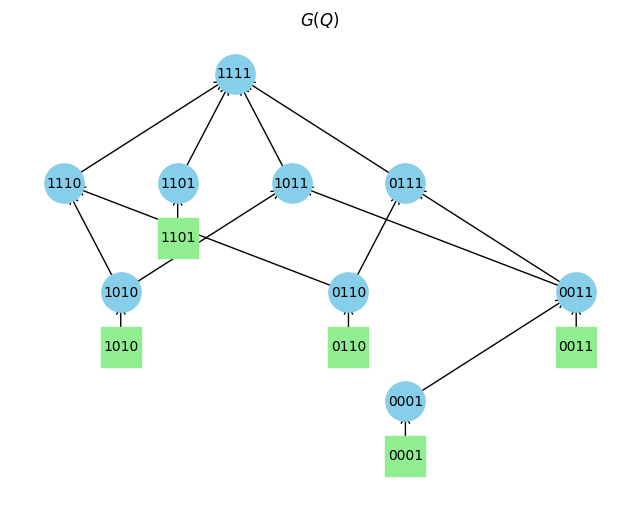

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).


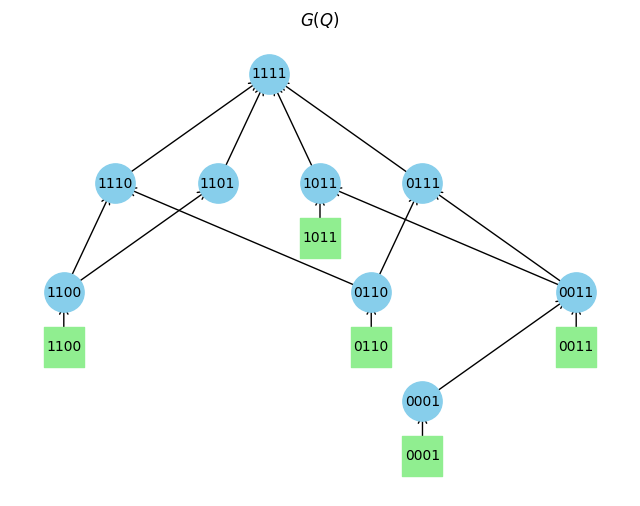

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is trivially not identifiable (all one column).
Q is not identifiable (two-column submatrix not identifiable).
Q is trivially not identifiable (all one column).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifia

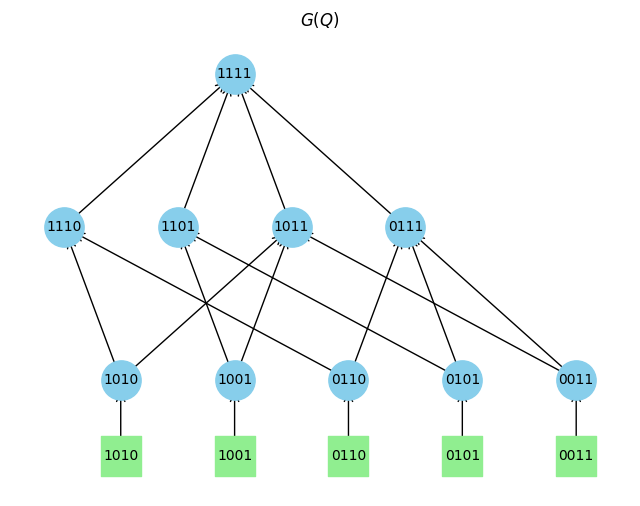

Q is not identifiable (two-column submatrix not identifiable).


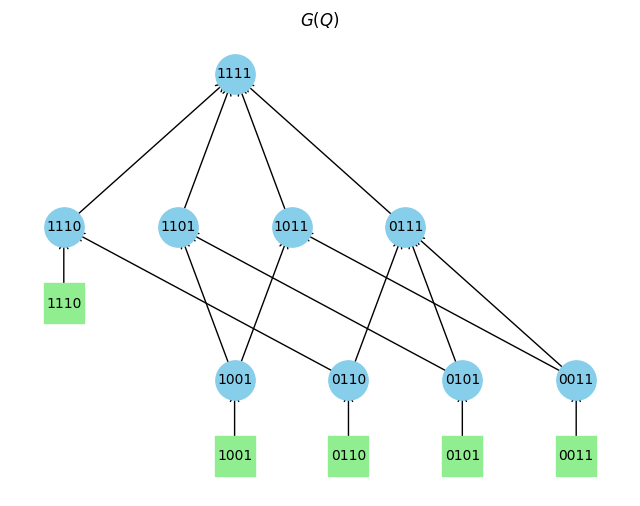

Q is not identifiable (two-column submatrix not identifiable).


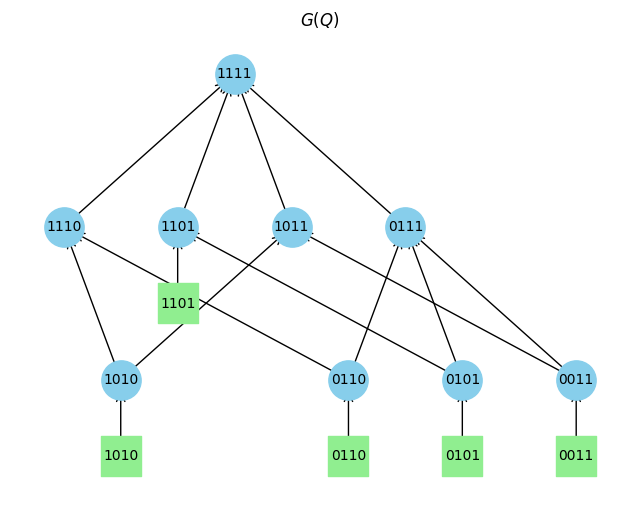

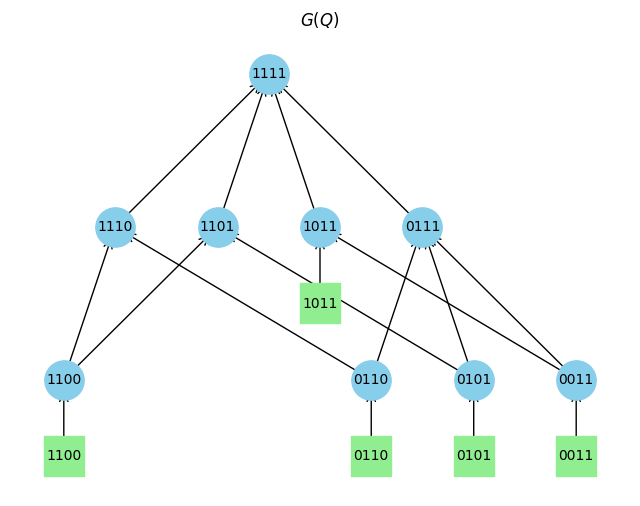

Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q_basis with dimensions J < K, thus not identifiable.
Q_basis with dimensions J < K, thus not identifiable.
Q_basis with dimensions J < K, thus not identifiable.
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q_basis with dimensions J < K, thus not identifiable.
Q is not identifiable (two-column submatrix not identifiable).
Q is trivially not identifiable (all one column).
Q is not identifiable (two-column submatrix not identifiable).
Q_basis with dimensions J < K, thus not identifiable.
Q_basis with dimensions J < K, thus not identifiable.
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiable).
Q is not identifiable (two-column submatrix not identifiabl

In [46]:
id_Q54 = []
id_Q54_withoutI = []
nid_Q54_id2 = []
nid_Q54_id3 = []
nid_Q54_ncol = []
for Q in generate_canonical_matrices(5, 4):
    idd, Q_bar = identifiability_debug(Q)
    if idd:
        id_Q54.append(Q)
        if not contains_identity_submatrix(Q):
            id_Q54_withoutI.append(Q)
            draw_G_K4(Q)
    else:
        if check_three_column_submatrices(Q) is None:
            nid_Q54_id3.append(Q)

In [47]:
len(id_Q54_withoutI)

20

In [ ]:
id_Q54 = []
id_Q54_withoutI2 = []
nid_Q54_id2 = []
nid_Q54_id3 = []
nid_Q54_ncol = []
for Q in generate_canonical_matrices(5, 4):
    idd, Q_bar = identifiability2(Q = Q)
    if idd:
        id_Q54.append(Q)
        if not contains_identity_submatrix(Q):
            id_Q54_withoutI2.append(Q)
            draw_G_K4(Q)
    else:
        if check_three_column_submatrices(Q) is None:
            nid_Q54_id3.append(Q)

In [ ]:
len(id_Q54_withoutI2)

In [ ]:
identifiability2(M)

In [ ]:
identifiability2(Q_test)

In [ ]:
# Step 1: get Q_basis
(Q_basis, basis_to_original, orig_indices_for_basis,
     Q_unique, unique_to_original, basis_to_unique) = get_basis(Q_test)

In [ ]:
print(sum(Q_basis[j, k] - Q_test_bar[j, k] for j in range(J_basis) for k in range(K)) >= 1)


In [ ]:
lex_sort_columns(M)

In [ ]:
Q_test_bar

In [ ]:
identifiability2(Q_test)

In [ ]:
identifiability2(Q_test)

In [ ]:
import numpy as np
import itertools

# A = 1×1 identity
A = np.array([[1]], dtype=int)

# B = 1×4 zero matrix
B = np.zeros((1, 4), dtype=int)

# C = 6×1 zero matrix
C = np.zeros((6, 1), dtype=int)

# D = all 6 binary vectors of length 4 with exactly two 1’s
D = np.array(
    [list(vec) for vec in itertools.product([0, 1], repeat=4) if sum(vec) == 2],
    dtype=int
)

# Assemble the 7×5 block matrix
M = np.block([
    [A, B],
    [C, D]
])

print("Block matrix M (7×5):")
print(M)


In [ ]:
identifiability2(M)

In [ ]:
import numpy as np

def generate_random_Q(J, K, density=0.5, random_seed=None):
    """
    Generate a random binary matrix Q of size J x K.

    Parameters:
    - J: Number of rows
    - K: Number of columns
    - density: Proportion of entries expected to be 1 (default 0.5)
    - random_seed: Random seed for reproducibility

    Returns:
    - Q: Random binary matrix
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    Q = np.random.choice([0, 1], size=(J, K), p=[1-density, density])
    return Q

# Example Usage:
if __name__ == "__main__":
    J, K = 50, 15  # moderate-sized example
    Q_test = generate_random_Q(J, K, density=0.3, random_seed=42)
    print("Generated Q matrix:")
    print(Q_test)


In [ ]:
cProfile.run('identifiability(Q_test)')

In [ ]:
model.setParam('SolutionLimit', 1)
model.setParam('MIPFocus', 1)      # heuristics first
model.setParam('TimeLimit', 60)    # cut off long searches
model.optimize()
if model.SolCount > 0:
    return False, ...              # witness found
# else reset limits and try to prove infeasibility


In [ ]:
# Step 1: Generate constraints Phi_a based on Q
Phi = list(unique_response_columns(Q))


In [ ]:
thmCheck2(Q, Q_bar, tol=1e-8)

In [ ]:
cProfile.run('identifiability2(M)')

In [ ]:
import numpy as np
import itertools

def generate_all_Q_basis(J, K):
    """
    Generate all possible binary matrices of size J x K.
    
    This function returns a generator that yields each binary matrix (as a NumPy array)
    in {0,1}^{JxK}.
    
    WARNING: The total number of matrices is 2^(J*K). This can quickly become intractable.
    
    Parameters:
      J (int): Number of rows.
      K (int): Number of columns.
      
    Yields:
      np.ndarray: A J x K binary matrix.
    """
    total = 2 ** (J * K)
    print(f"Warning: There are {total} matrices; ensure that J and K are small enough!")
    # Generate each matrix by creating a tuple of J*K binary digits and reshaping into (J, K).
    for bits in itertools.product([0, 1], repeat=J*K):
        yield np.array(bits, dtype=int).reshape(J, K)

# Example usage:
if __name__ == "__main__":
    # For a small test, say J=2, K=3, yielding 2^6=64 matrices.
    J, K = 2, 3
    gen = generate_all_Q_basis(J, K)
    
    # Print the first 5 matrices:
    for i, Q in enumerate(gen):
        if i >= 5:
            break
        print(f"Matrix {i+1}:")
        print(Q)
        print()


# generate_all_Q_basis

In [ ]:
import numpy as np
import itertools

def generate_all_Q_basis(J, K):
    """
    Generate all possible binary matrices of size J x K.
    
    This function returns a generator that yields each binary matrix (as a NumPy array)
    in {0,1}^{JxK}.
    
    WARNING: The total number of matrices is 2^(J*K). This can quickly become intractable.
    
    Parameters:
      J (int): Number of rows.
      K (int): Number of columns.
      
    Yields:
      np.ndarray: A J x K binary matrix.
    """
    total = 2 ** (J * K)
    print(f"Warning: There are {total} matrices; ensure that J and K are small enough!")
    # Generate each matrix by creating a tuple of J*K binary digits and reshaping into (J, K).
    for bits in itertools.product([0, 1], repeat=J*K):
        yield np.array(bits, dtype=int).reshape(J, K)

# Example usage:
if __name__ == "__main__":
    # For a small test, say J=2, K=3, yielding 2^6=64 matrices.
    J, K = 2, 3
    gen = generate_all_Q_basis(J, K)
    
    # Print the first 5 matrices:
    for i, Q in enumerate(gen):
        if i >= 5:
            break
        print(f"Matrix {i+1}:")
        print(Q)
        print()


In [ ]:
cProfile.run('identifiability1(M)')
cProfile.run('identifiability2(M)')

In [ ]:
def brute_check_id1(Q_basis):
    """
    Perform candidate generation on the basis matrix Q_basis to check the identifiability.
    
    Q_basis is the matrix obtained after removing all-zero, duplicate, and generated rows.
    
    The function generates candidate Q_basis_bar matrices by modifying the replaceable rows of Q_basis.
    It returns a tuple (status, Q_basis_bar) where:
      - status == 0 indicates that Q_basis is not identifiable and Q_basis_bar is a candidate,
      - status == 1 indicates that Q_basis is identifiable (and no candidate is found).
    
    Note: Lifting Q_basis_bar back to the full Q will be handled in the main function.
    """
    J_basis, K = Q_basis.shape
    distances = distances2U(Q_basis)
    irreplaceable_rows = np.where(np.array(distances) == K - 1)[0]
    replaceable_rows = set(range(J_basis)) - set(irreplaceable_rows)
    
    replacement_indices = list(replaceable_rows)
    subQ_bars = []
    for i in range(len(replacement_indices)):
        index = replacement_indices[i]
        q_bars = []
        for p in range(1, K - distances[index] + 1):
            q_bars.extend(generate_binary_vectors(K, p))
        valid_q_bars = []
        Q_temp = Q_basis.copy()
        for q_bar in q_bars:
            Q_temp[index, :] = q_bar
            if preserve_partial_order(Q_basis, Q_temp, set(irreplaceable_rows), [index]):
                valid_q_bars.append(q_bar)
        subQ_bars.append(valid_q_bars)
    
    # Generate Cartesian product of candidate replacements.
    subQ_bars = itertools.product(*subQ_bars)
    Q_bar_gen = generate_unique_Q_bars(subQ_bars, Q_basis, replacement_indices)


    cols_phiQ = unique_response_columns(Q_basis)
    for Q_basis_bar in Q_bar_gen:
        candidate_valid = True  
        for S in cols_phiQ:
            S_arr = np.array(S, dtype=int)
            idx_active = [j for j in range(J_basis) if S_arr[j] == 1]

            # Compute h_a: the logical OR of the rows of Q_basis_bar indexed by idx_active.
            if idx_active:
                h_a = Q_basis_bar[idx_active[0]].copy()
                for j in idx_active[1:]:
                    h_a = np.logical_or(h_a, Q_basis_bar[j]).astype(int)
            else:
                h_a = np.zeros(K, dtype=int)

            # Now check if there is any row j not in idx_active such that Q_basis_bar[j] <= h_a.
            # If so, then the response computed from h_a would have an extra 1, differing from S.
            for j in range(J_basis):
                if j in idx_active:
                    continue  # These rows are by construction "covered"
                if np.all(Q_basis_bar[j] <= h_a):
                    # Found an extra match not corresponding to S.
                    candidate_valid = False
                    break  # No need to check further S for this candidate.

            if not candidate_valid:
                # One S failed, so break out immediately to try the next Q_basis_bar.
                break

        if candidate_valid:
            return 0, Q_basis_bar
    return 1, None 

### This function checks if Q is identifiable, if not, it returns one possible Q_bar.
def identifiability1(Q):
    Q = Q.copy()
    
    # Step 1: get Q_basis
    (Q_basis, basis_to_original, orig_indices_for_basis,
         Q_unique, unique_to_original, basis_to_unique) = get_basis(Q)
    
    J_basis, K = Q_basis.shape
    
    if J_basis < K:
        Q_basis_bar = np.eye(K, dtype=int)[:J_basis]
        Q_bar = get_Q_from_Qbasis(Q_basis_bar, basis_to_original)
        print("Q_basis with dimensions J < K, thus not identifiable.")
        return 0, Q_bar
    # All subsequent candidate generation is performed on Q_basis.
    # Step 3: Check for trivial non-identifiability on Q_basis.
    for k in range(K):
        if np.all(Q_basis[:, k] == 0):
            Q_basis_bar = Q_basis.copy()
            Q_basis_bar[:, k] = 1
            print("Q is trivially not identifiable (all zero column).")
            Q_bar = get_Q_from_Qbasis(Q_basis_bar, basis_to_original)
            return 0, Q_bar
        if np.all(Q_basis[:, k] == 1):
            Q_basis_bar = Q_basis.copy()
            Q_basis_bar[:, k] = 0
            print("Q is trivially not identifiable (all one column).")
            Q_bar = get_Q_from_Qbasis(Q_basis_bar, basis_to_original)
            return 0, Q_bar

    candidate = check_two_column_submatrices(Q_basis)
    if candidate is not None:
        print("Q is not identifiable (two-column submatrix not identifiable).")
        Q_basis_bar = candidate
        Q_bar = get_Q_from_Qbasis(Q_basis_bar, basis_to_original)
        return 0, Q_bar

    candidate = check_three_column_submatrices(Q_basis)
    if candidate is not None:
        print("Q is not identifiable (three-column submatrix not identifiable).")
        Q_basis_bar = candidate
        Q_bar = get_Q_from_Qbasis(Q_basis_bar, basis_to_original)
        return 0, Q_bar

    # Step 4: Determine identifiability of Q_basis.
    if direct_check_id(Q_basis):
        print("Q is identifiable (direct_check).")
        return 1, None
    else:
        status, Q_basis_bar = brute_check_id1(Q_basis)
        if status == 0:
            print("Q is not identifiable (brute_check_id).")
            Q_bar = get_Q_from_Qbasis(Q_basis_bar, basis_to_original)
            return 0, Q_bar
        else:
            print("Q is identifiable (brute_check).")
            return 1, None
        
def brute_check_id2(Q_basis):
    J_basis, K = Q_basis.shape
    distances = distances2U(Q_basis)
    irreplaceable_rows = np.where(np.array(distances) == K - 1)[0]
    replaceable_rows = set(range(J_basis)) - set(irreplaceable_rows)
    
    replacement_indices = list(replaceable_rows)
    subQ_bars = []
    for i in range(len(replacement_indices)):
        index = replacement_indices[i]
        q_bars = []
        for p in range(1, K - distances[index] + 1):
            q_bars.extend(generate_binary_vectors(K, p))
        valid_q_bars = []
        Q_temp = Q_basis.copy()
        for q_bar in q_bars:
            Q_temp[index, :] = q_bar
            if preserve_partial_order(Q_basis, Q_temp, set(irreplaceable_rows), [index]):
                valid_q_bars.append(q_bar)
        subQ_bars.append(valid_q_bars)
    
    # Generate Cartesian product of candidate replacements.
    subQ_bars = itertools.product(*subQ_bars)
    Q_bar_gen = generate_unique_Q_bars2(subQ_bars, Q_basis, replacement_indices)


    cols_phiQ = unique_response_columns(Q_basis)
    for Q_basis_bar in Q_bar_gen:
        candidate_valid = True  
        for S in cols_phiQ:
            S_arr = np.array(S, dtype=int)
            idx_active = [j for j in range(J_basis) if S_arr[j] == 1]

            # Compute h_a: the logical OR of the rows of Q_basis_bar indexed by idx_active.
            if idx_active:
                h_a = Q_basis_bar[idx_active[0]].copy()
                for j in idx_active[1:]:
                    h_a = np.logical_or(h_a, Q_basis_bar[j]).astype(int)
            else:
                h_a = np.zeros(K, dtype=int)

            # Now check if there is any row j not in idx_active such that Q_basis_bar[j] <= h_a.
            # If so, then the response computed from h_a would have an extra 1, differing from S.
            for j in range(J_basis):
                if j in idx_active:
                    continue  # These rows are by construction "covered"
                if np.all(Q_basis_bar[j] <= h_a):
                    # Found an extra match not corresponding to S.
                    candidate_valid = False
                    break  # No need to check further S for this candidate.

            if not candidate_valid:
                # One S failed, so break out immediately to try the next Q_basis_bar.
                break

        if candidate_valid:
            return 0, Q_basis_bar
    return 1, None 

### This function checks if Q is identifiable, if not, it returns one possible Q_bar.
def identifiability2(Q):
    Q = Q.copy()
    
    # Step 1: get Q_basis
    (Q_basis, basis_to_original, orig_indices_for_basis,
         Q_unique, unique_to_original, basis_to_unique) = get_basis(Q)
    
    J_basis, K = Q_basis.shape
    
    if J_basis < K:
        Q_basis_bar = np.eye(K, dtype=int)[:J_basis]
        Q_bar = get_Q_from_Qbasis(Q_basis_bar, basis_to_original)
        print("Q_basis with dimensions J < K, thus not identifiable.")
        return 0, Q_bar
    # All subsequent candidate generation is performed on Q_basis.
    # Step 3: Check for trivial non-identifiability on Q_basis.
    for k in range(K):
        if np.all(Q_basis[:, k] == 0):
            Q_basis_bar = Q_basis.copy()
            Q_basis_bar[:, k] = 1
            print("Q is trivially not identifiable (all zero column).")
            Q_bar = get_Q_from_Qbasis(Q_basis_bar, basis_to_original)
            return 0, Q_bar
        if np.all(Q_basis[:, k] == 1):
            Q_basis_bar = Q_basis.copy()
            Q_basis_bar[:, k] = 0
            print("Q is trivially not identifiable (all one column).")
            Q_bar = get_Q_from_Qbasis(Q_basis_bar, basis_to_original)
            return 0, Q_bar

    candidate = check_two_column_submatrices(Q_basis)
    if candidate is not None:
        print("Q is not identifiable (two-column submatrix not identifiable).")
        Q_basis_bar = candidate
        Q_bar = get_Q_from_Qbasis(Q_basis_bar, basis_to_original)
        return 0, Q_bar

    candidate = check_three_column_submatrices(Q_basis)
    if candidate is not None:
        print("Q is not identifiable (three-column submatrix not identifiable).")
        Q_basis_bar = candidate
        Q_bar = get_Q_from_Qbasis(Q_basis_bar, basis_to_original)
        return 0, Q_bar

    # Step 4: Determine identifiability of Q_basis.
    if direct_check_id(Q_basis):
        print("Q is identifiable (direct_check).")
        return 1, None
    else:
        status, Q_basis_bar = brute_check_id2(Q_basis)
        if status == 0:
            print("Q is not identifiable (brute_check_id).")
            Q_bar = get_Q_from_Qbasis(Q_basis_bar, basis_to_original)
            return 0, Q_bar
        else:
            print("Q is identifiable (brute_check).")
            return 1, None
    

In [ ]:
id_Q54 = []
id_Q54_withoutI = []
nid_Q54_id2 = []
nid_Q54_id3 = []
nid_Q54_ncol = []
for Q in generate_canonical_matrices(5, 4):
    idd, Q_bar = identifiability(Q = Q)
    if idd:
        id_Q54.append(Q)
        if not contains_identity_submatrix(Q):
            id_Q54_withoutI.append(Q)
    else:
        if check_three_column_submatrices(Q) is None:
            nid_Q54_id3.append(Q)
            draw_G_K4(Q)
            print(Q)

In [ ]:
len(id_Q54_withoutI)

In [ ]:
from idQ import thmCheck

In [ ]:
for Q in nid_Q54_id3:
    idd, Q_bar = identifiability(Q = Q)
    PhiQ = Phi_mat(Q)
    PhiB = Phi_mat(Q_bar)
    checks = thmCheck(PhiQ, PhiB, tol=1e-8)
    print(checks)
    print(Q)
    print(Q_bar)

In [ ]:
id_Q54 = []
id_Q54_withoutI = []
nid_Q54_id2 = []
nid_Q54_id3 = []
nid_Q54_ncol = []
for Q in generate_canonical_matrices(5, 4):
    idd, Q_bar = identifiability(Q = Q)
    if idd:
        id_Q54.append(Q)
        if not contains_identity_submatrix(Q):
            id_Q54_withoutI.append(Q)
            draw_G_K4(Q)
    else:
        if check_three_column_submatrices(Q) is None:
            nid_Q54_id3.append(Q)

In [ ]:
len(id_Q65_withoutI)

In [ ]:
QQ = id_Q65_withoutI[27]
draw_G_K5(QQ)

In [ ]:
QQ

In [ ]:
QQ1= np.array([[0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 1, 1],
       [1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0]
         ])
draw_G_K5(QQ1)
identifiability(QQ1)

In [ ]:
bQQ1 = np.array([[0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 1, 1],
       [1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0],
       [1, 0, 1, 1, 0]])
draw_G_K5(bQQ1)
identifiability(bQQ1)

In [ ]:
Phi_mat_analysis(QQ1)

In [ ]:
# This function checks whether row1 is less than or equal to row2.
def is_less_equal_than(row1, row2):
    return np.all(row1 <= row2)

In [ ]:
import itertools
import numpy as np

def Phi_mat_analysis(Q):
    """
    Analyzes the Phi matrix of Q.
    
    For each latent vector a in {0,1}^K (K = number of columns in Q),
    it computes the response vector:
    
        [ is_less_equal_than(Q[j], a) for j in range(J) ]
    
    where is_less_equal_than returns a Boolean (converted to int).
    
    It then groups latent vectors that produce the same response pattern.
    Using representative_node_set(Q), it identifies the representative latent
    vector for each group, and prints:
    
        - The representative latent vector
        - All latent vectors that share the same responses
        - Their shared response pattern (as a tuple of 0's and 1's)
    
    Parameters:
        Q (np.ndarray): A J×K binary matrix.
    """
    J, K = Q.shape
    # Generate all latent vectors in {0,1}^K
    AA = [tuple(seq) for seq in itertools.product([0, 1], repeat=K)]
    
    # Compute a mapping from each latent vector to its response pattern.
    # Each response pattern is a tuple of length J.
    latent_to_response = {}
    for a in AA:
        response = tuple(int(is_less_equal_than(Q[j], a)) for j in range(J))
        latent_to_response[a] = response
    
    # Invert the mapping: group latent vectors by their response pattern.
    response_to_latents = {}
    for a, response in latent_to_response.items():
        response_to_latents.setdefault(response, []).append(a)
    
    # Get the representative node set for Q.
    reps = representative_node_set(Q)  # This is a set of tuples (latent vectors)
    
    # For each group (each distinct response pattern), select the representative latent vector.
    for response, latent_vectors in response_to_latents.items():
        rep = None
        # Choose the representative as the first latent vector in the group that is in reps.
        for a in latent_vectors:
            if a in reps:
                rep = a
                break
        # If none of the latent vectors is in reps (unlikely), choose the first one.
        if rep is None:
            rep = latent_vectors[0]
        # Print the analysis for this group.
        print("Representative latent vector:", rep)
        print("Latent vectors with the same responses:", latent_vectors)
        print("Shared responses:", response)
        print("-" * 40)


In [ ]:
len(id_Q54_withoutI)

In [ ]:
from idQ import canonicalize
def generate_unique_Q_bars2(subQ_bars, Q, replacement_indices):
    
    """
    Generate candidate Q_bar matrices from the Cartesian product subQ_bars,
    yielding only one representative per permutation equivalence class.
    The canonical form of Q is added to the 'seen' set so that any candidate
    equivalent to Q is automatically filtered out.
    
    Parameters:
        subQ_bars (iterable): Cartesian product of candidate replacement rows.
        Q (np.ndarray): The input Q-matrix.
        replacement_indices (list): Indices of rows in Q to be replaced.
    
    Yields:
        np.ndarray: A candidate Q_bar that is not permutation equivalent to Q.
    """
    
    seen = set()
    canonical_Q = canonicalize(Q)
    seen.add(canonical_Q.tostring())
    
    for subQ_bar_replacements in subQ_bars:
        # Check if the candidate for replacements is empty:
        if len(subQ_bar_replacements) == 0:
            continue  # skip this candidate
        
        Q_bar = Q.copy()
        candidate = np.array(subQ_bar_replacements)
        # Ensure candidate has the correct shape. If candidate.ndim == 1, reshape it.
        if candidate.ndim == 1:
            candidate = candidate.reshape(1, -1)
        
        Q_bar[replacement_indices, :] = candidate
        can_form = canonicalize(Q_bar)
        key = can_form.tostring()
        if key not in seen:
            seen.add(key)
            yield Q_bar

In [ ]:
id_Q64 = []
id_Q64_withoutI = []
nid_Q64_id2 = []
nid_Q64_id3 = []
nid_Q64_ncol = []
for Q in generate_canonical_matrices(6, 4):
    idd, Q_bar = identifiability(Q = Q)
    if idd:
        id_Q64.append(Q)
        if not contains_identity_submatrix(Q):
            id_Q64_withoutI.append(Q)

In [ ]:
import csv
csv_filename = "identifiable_Q/identifiable_Q_K4_J6.csv"

with open(csv_filename, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    for idx, matrix in enumerate(id_Q64_withoutI):
        # Write a header for each matrix.
        writer.writerow([f"Matrix {idx}"])
        # Write each row of the matrix.
        for row in matrix:
            writer.writerow(row.tolist())
        # Write a blank row as a separator.
        writer.writerow([])


In [ ]:
id_Q64 = []
id_Q64_withoutI = []
nid_Q64_id2 = []
nid_Q64_id3 = []
nid_Q64_ncol = []
for Q in generate_canonical_matrices(6, 4):
    idd, Q_bar = identifiability(Q = Q)
    if idd:
        id_Q64.append(Q)
        if not contains_identity_submatrix(Q):
            id_Q64_withoutI.append(Q)
            draw_G_K4(Q)

In [ ]:
len(id_Q64_withoutI)

In [ ]:
len(id_Q64)

In [ ]:
len(generate_canonical_matrices(6, 4))

In [ ]:
id_Q64 = []
id_Q64_withoutI = []
nid_Q64_id2 = []
nid_Q64_id3 = []
nid_Q64_ncol = []
for Q in generate_canonical_matrices(6, 4):
    idd, Q_bar = identifiability(Q = Q)
    if idd:
        id_Q64.append(Q)
        if not contains_identity_submatrix(Q):
            id_Q64_withoutI.append(Q)
            draw_G_K4(Q)

In [ ]:
import numpy as np

result = []
for Q in id_Q54_withoutI:
    # Get the set of representative node rows and the set of current item node rows
    R_Q = representative_node_set(Q)
    I_Q = item_node_set(Q)
    # Determine which representative rows are not already present in Q
    new_rows = R_Q - I_Q
    for q in new_rows:
        # Create a new Q by appending q to Q.
        # We first convert each row of Q to a list of integers (binary values)
        newQ_list = [list(map(int, row)) for row in Q]
        # Convert the candidate row q to a list of integers
        new_row = list(map(int, q))
        newQ_list.append(new_row)
        # Convert newQ_list to a NumPy array with integer type to ensure it's a binary matrix
        newQ = np.array(newQ_list, dtype=int)
        # Check if newQ is non-identifiable
        if not identifiability(newQ):
            # Optionally, you might want to store the original Q as a binary matrix too
            result.append((np.array(Q, dtype=int), newQ))


In [ ]:
result

In [ ]:
import numpy as np

result = []
for Q in id_Q54_withoutI:
    # Get the set of representative node rows and the set of current item node rows
    R_Q = representative_node_set(Q)
    I_Q = item_node_set(Q)
    # Determine which representative rows are not already present in Q
    new_rows = R_Q - I_Q
    for q in new_rows:
        # Create a new Q by appending q to Q.
        # We first convert each row of Q to a list of integers (binary values)
        newQ_list = [list(map(int, row)) for row in Q]
        # Convert the candidate row q to a list of integers
        new_row = list(map(int, q))
        newQ_list.append(new_row)
        # Convert newQ_list to a NumPy array with integer type to ensure it's a binary matrix
        newQ = np.array(newQ_list, dtype=int)
        # Check if newQ is non-identifiable
        if not identifiability(newQ):
            # Optionally, you might want to store the original Q as a binary matrix too
            result.append((np.array(Q, dtype=int), newQ))


In [ ]:
len(id_Q54_withoutI)

In [ ]:
len(id_Q54)

In [ ]:
difference = [Q for Q in id_Q54 if not any(np.array_equal(Q, Q_without) for Q_without in id_Q54_withoutI)]
difference

In [ ]:
id_Q54_withoutI[0]

In [ ]:
Q = id_Q54_withoutI[0]
Q

In [ ]:
# Compute G_matrix of Q
def G_mat(Q, unique = True):
    J, K = Q.shape
    pp = [seq for seq in itertools.product([0, 1], repeat=K)]
    GG = []
    for j in range(J):
        GG.append((list(is_less_equal_than(Q[j,:], p) for p in pp)))
    GG = np.array(GG)*1
    if unique:
        return(np.unique(GG, axis = 1))
    return GG

In [ ]:
Q1 = Q

In [ ]:
Q2 = Q.copy

In [ ]:
Q2[2,3] = 0

In [ ]:
Q2

In [ ]:
Q

In [ ]:
G_mat(Q)

In [ ]:
G_mat(Q)

In [ ]:
G_mat(Q)

In [ ]:
np.unique(GG, axis = 1).T

In [ ]:
for Q in id_Q54_withoutI:
    print(G_mat(Q))

## There are 20 number of Q that are identifiable without containing an identity matrix.

In [ ]:
len(nid_Q54_id2)

## There are 17 of not identifiable Q that satisfies necc(2).

In [ ]:
len(nid_Q54_id3)

In [ ]:
nid_Q54_ncol

## There are no not identifiable Q s.t. the column space condition violates.

## There are 6 of not identifiable Q that satisfies necc(2).

In [ ]:
for Q in nid_Q54_id2:
    print(Any_two_columns_contain_I(Q))

In [ ]:
Q = nid_Q54_id3[0]
Q

In [ ]:
_, Q_bar = identifiability(Q = Q)
Q_bar = Q_bar[0]

In [ ]:
nid_Q54_id3 = []
for Q in nid_Q54_ncol:
    if any_3_columns_id(Q):
        nid_Q54_id3.append(Q)

# Fraction Data

In [ ]:
Q = np.array([
    [0, 0, 0, 1, 0, 1, 1, 0],
    [0, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 0, 1, 0, 0, 1, 0],
    [0, 1, 1, 0, 1, 0, 1, 0],
    [0, 1, 0, 1, 0, 0, 1, 1],
    [0, 0, 0, 0, 0, 0, 1, 0],
    [1, 1, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 1, 0],
    [0, 1, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 1, 1],
    [0, 1, 0, 0, 1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 1, 1],
    [0, 1, 0, 1, 1, 0, 1, 0],
    [0, 1, 0, 0, 0, 0, 1, 0],
    [1, 0, 0, 0, 0, 0, 1, 0],
    [0, 1, 0, 0, 0, 0, 1, 0],
    [0, 1, 0, 0, 1, 0, 1, 0],
    [0, 1, 0, 0, 1, 1, 1, 0],
    [1, 1, 1, 0, 1, 0, 1, 0],
    [0, 1, 1, 0, 1, 0, 1, 0]
])

In [ ]:
# Find unique rows and their indices
unique_rows, indices = np.unique(Q, axis=0, return_index=True)

# Find duplicate rows
duplicate_rows = np.delete(np.arange(Q.shape[0]), indices)

print("Duplicate rows:", duplicate_rows)

Q.shape

Q_unique = np.unique(Q, axis=0)
Q_unique.shape

Q_unique